In [ ]:
# aaron elcheson
# sept.11/2025

**Step 1 — Data + folders (AVITI)**
-----
-----------
------------

**Purpose**
--
-------

- We will analyze real Element AVITI bulk RNA-seq data with a full workflow: Salmon quantification → tximport → edgeR/limma-voom; CAMERA/FRY, that allows us to generate gene hits, perform differential expression (DE), and analyze gene set enrichment pathways.
- This notebook is designed so that you can drop in **your own bulk RNA-seq FASTQs from next-generation sequencing instruments (Element AVITI, Illumina, etc...)** and run the analysis workflow; filenames do not have to follow a particular pattern.

------------

**What you should have already uploaded to Google Drive**
----------------

Create this folder layout and place files exactly as shown:

/content/drive/MyDrive/rnaseq_colab/

├── fastq/          ← put ALL paired-end FASTQs here (R1/R2 for each run; any names are fine)  
├── ref/            ← put reference files here (human, Ensembl GRCh38 release 111)  
│   ├── Homo_sapiens.GRCh38.cdna.all.fa.gz  
│   └── Homo_sapiens.GRCh38.111.gtf.gz  
└── quant/          ← leave empty; Salmon will write results here

------------------

**About the example dataset we’ll use**
--------

- Study: AVITI bulk RNA-seq of MDA-MB-231 cells in engineered bone-marrow tissues  
- Groups: OB (osteoblast-only) vs ME (mesenchymal + endothelial)  
- For a minimal DE example, use ≥2 runs per group (4 runs total).
- Filenames can be anything (e.g., SRR…_1.fastq.gz / SRR…_2.fastq.gz or lab names like ME_s1_R1.fastq.gz / ME_s1_R2.fastq.gz).

------------
---------------

**What the next code cell will do**
---------------
--------------------------

1) Mount Drive and verify the three folders above exist.  
2) List everything you uploaded under fastq/ and ref/.  
3) Install RPY2, Salmon, limma voom, R and python packages to configure the environment

---------------------

**After this step**
--
--------------

**We will:**

- build a Salmon index from the Ensembl FASTA in ref,  
- quantify all discovered samples into quant,  
- import counts with tximport and run limma-voom,  
- perform DE (ME vs OB)


# FASTQs (list via ENA filereport for PRJNA1164191)
https://www.ebi.ac.uk/ena/portal/api/filereport?accession=PRJNA1164191&result=read_run&fields=run_accession,fastq_ftp,library_layout,instrument_model,sample_title&format=tsv

# Reference files (Ensembl GRCh38, release 111)
https://ftp.ensembl.org/pub/release-111/fasta/homo_sapiens/cdna/Homo_sapiens.GRCh38.cdna.all.fa.gz
https://ftp.ensembl.org/pub/release-111/gtf/homo_sapiens/Homo_sapiens.GRCh38.111.gtf.gz


**ME CELLS: SAMPLES 1 and 2 (Runs 1 and 2 for each sample)**
--
-----------


- Element AVITI	MDA-MB-231 cells cultured in endosteal bone seeded with mesenchymal stem cells and endothelial cells sample 1

- Element AVITI	MDA-MB-231 cells cultured in endosteal bone seeded with mesenchymal stem cells and endothelial cells sample 2


-----------------

**OB CELLS: SAMPLES 1 and 2 (Runs 1 and 2 for each sample)**
--
--------------


- Element AVITI	MDA-MB-231 cells cultured in endosteal bone containing only osteoblasts (OB) sample 1

- Element AVITI	MDA-MB-231 cells cultured in endosteal bone containing only osteoblasts (OB) sample 2

-----------

**Reference Paper**
---
-----

https://pubmed.ncbi.nlm.nih.gov/39374382/

GEO series: GSE277786 — “An engineered model of metastatic colonization of human bone marrow reveals breast cancer cell remodeling of the hematopoietic niche.”

Platform: Element AVITI (GPL34295). Design: ME (MDA-MB-231 on endosteal bone with mesenchymal + endothelial) vs OB (osteoblast-only). The GEO page links to SRA runs and also provides a small raw counts text file.


In [ ]:
# Cell 1 — Mount Drive & define project folders (minimal)

from google.colab import drive
from pathlib import Path
import os

drive.mount('/content/drive')

BASE = Path("/content/drive/MyDrive/rnaseq_colab")
FASTQ_DIR = BASE / "fastq"   # your paired FASTQs (R1/R2) are here
REF_DIR   = BASE / "ref"     # transcriptome FASTA + GTF are here
QUANT_DIR = BASE / "quant"   # Salmon outputs will go here
for d in (FASTQ_DIR, REF_DIR, QUANT_DIR): d.mkdir(parents=True, exist_ok=True)

os.environ["DRIVE_DIR"] = str(BASE)
os.environ["FASTQ_DIR"] = str(FASTQ_DIR)
os.environ["REF_DIR"]   = str(REF_DIR)
os.environ["QUANT_DIR"] = str(QUANT_DIR)

print("Ready:", "\n FASTQ_DIR =", FASTQ_DIR, "\n REF_DIR   =", REF_DIR, "\n QUANT_DIR =", QUANT_DIR)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Ready: 
 FASTQ_DIR = /content/drive/MyDrive/rnaseq_colab/fastq 
 REF_DIR   = /content/drive/MyDrive/rnaseq_colab/ref 
 QUANT_DIR = /content/drive/MyDrive/rnaseq_colab/quant


**ENVIRONMENT SETUP: RPY2, Salmon, R packages for Limma Voom**
---

In [ ]:

## Cell A — Python: rpy2 + folders (run this)

# rpy2 so we can run %%R cells
%pip install -q rpy2==3.5.16
%load_ext rpy2.ipython

from pathlib import Path

# Project folders
DRIVE_DIR = Path("/content/drive/MyDrive/rnaseq_colab")
LOCAL_DIR = Path("/content/rnaseq_work")
DRIVE_DIR.mkdir(parents=True, exist_ok=True)
LOCAL_DIR.mkdir(parents=True, exist_ok=True)
print(f"DRIVE_DIR = {DRIVE_DIR}")
print(f"LOCAL_DIR = {LOCAL_DIR}")


DRIVE_DIR = /content/drive/MyDrive/rnaseq_colab
LOCAL_DIR = /content/rnaseq_work


In [ ]:
%%bash
set -euo pipefail

# 1) Install micromamba binary
if ! command -v micromamba >/dev/null 2>&1; then
  curl -Ls https://micro.mamba.pm/api/micromamba/linux-64/latest | tar -xvj -C /usr/local/bin bin/micromamba --strip-components=1
fi
micromamba --version

# 2) Create env with salmon + sra-tools
ROOT=/content/micromamba
ENV=rnaseq
if [ ! -d "$ROOT/envs/$ENV" ]; then
  /usr/local/bin/micromamba create -y -r "$ROOT" -n "$ENV" -c conda-forge -c bioconda \
    salmon=1.10.2 sra-tools=3.0.* >/dev/null
fi

# 3) Symlink key tools into /usr/local/bin so they’re on PATH in all cells
ln -sf "$ROOT/envs/$ENV/bin/salmon"        /usr/local/bin/salmon
ln -sf "$ROOT/envs/$ENV/bin/fasterq-dump"  /usr/local/bin/fasterq-dump
ln -sf "$ROOT/envs/$ENV/bin/prefetch"      /usr/local/bin/prefetch
ln -sf "$ROOT/envs/$ENV/bin/vdb-config"    /usr/local/bin/vdb-config

# 4) SRA cache
mkdir -p /content/sra_cache
vdb-config -s /repository/user/main/public/root=/content/sra_cache || true

# 5) Show versions as sanity check
echo "---- Versions ----"
salmon --version
fasterq-dump --version | head -n 1 || true
echo "------------------"


bin/micromamba
2.3.2
---- Versions ----
salmon 1.10.2

------------------


warning  libmamba [perl-xml-sax-base-1.08-0] The following files were already present in the environment:
    - lib/perl5/5.22.0/x86_64-linux-thread-multi/perllocal.pod
warning  libmamba [perl-xml-namespacesupport-1.11-0] The following files were already present in the environment:
    - lib/perl5/5.22.0/x86_64-linux-thread-multi/perllocal.pod
2025-09-11T19:18:49 vdb-config.3.0.10 err: condition violated while updating node - Warning: normally this application should not be run as root/superuser


In [ ]:
# Refresh PATH/symlinks so 'which' shows /usr/local/bin and versions print
import os, shutil, subprocess
from pathlib import Path

# Re-link common SRA tools from the micromamba env (if not already linked)
ROOT = Path("/content/micromamba")
ENV  = ROOT / "envs" / "rnaseq" / "bin"
for tool in ["fasterq-dump","prefetch","vdb-config","salmon"]:
    src = ENV / tool
    dst = Path("/usr/local/bin") / tool
    if src.exists() and not dst.exists():
        dst.symlink_to(src)

# Force shell to rehash its command cache
subprocess.run("hash -r", shell=True)

# Show versions
!command -v salmon && salmon --version
!command -v fasterq-dump && (fasterq-dump --version 2>&1 | head -n 1)
!command -v prefetch || echo "prefetch missing (optional)"


/usr/local/bin/salmon
salmon 1.10.2
/usr/local/bin/fasterq-dump

/usr/local/bin/prefetch


In [ ]:
%%R
# Use a binary CRAN for Ubuntu 22.04 (Colab) to speed things up
options(repos = c(CRAN = "https://packagemanager.posit.co/cran/__linux__/jammy/latest"))

# Make sure BiocManager is present
if (!requireNamespace("BiocManager", quietly = TRUE)) install.packages("BiocManager", quiet = TRUE)

# Let BiocManager pick the correct Bioconductor release for this R (avoid mismatches)
BiocManager::install(ask = FALSE, update = FALSE)

# Install needed packages; many will come as binaries here
pkgs <- c("limma","edgeR","tximport","readr","Matrix","BiocParallel")
need <- pkgs[!vapply(pkgs, requireNamespace, logical(1), quietly = TRUE)]
if (length(need)) BiocManager::install(need, ask = FALSE, update = FALSE, Ncpus = 2)

# Show versions as a sanity check
print(sapply(pkgs, function(p) as.character(packageVersion(p))))


       limma        edgeR     tximport        readr       Matrix BiocParallel 
    "3.64.3"      "4.6.3"     "1.36.1"      "2.1.5"      "1.7.4"     "1.42.1" 


'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://packagemanager.posit.co/cran/__linux__/jammy/latest
Bioconductor version 3.21 (BiocManager 1.30.26), R 4.5.1 (2025-06-13)


In [ ]:
%%R
suppressPackageStartupMessages({
  library(limma); library(edgeR); library(tximport)
})
print(sessionInfo()$otherPkgs[c("limma","edgeR","tximport")])


$limma
Package: limma
Version: 3.64.3
Date: 2025-07-30
Title: Linear Models for Microarray and Omics Data
Description: Data analysis, linear models and differential expression
        for omics data.
Author: Gordon Smyth [cre,aut], Yifang Hu [ctb], Matthew Ritchie [ctb],
        Jeremy Silver [ctb], James Wettenhall [ctb], Davis McCarthy
        [ctb], Di Wu [ctb], Wei Shi [ctb], Belinda Phipson [ctb], Aaron
        Lun [ctb], Natalie Thorne [ctb], Alicia Oshlack [ctb], Carolyn
        de Graaf [ctb], Yunshun Chen [ctb], Goknur Giner [ctb], Mette
        Langaas [ctb], Egil Ferkingstad [ctb], Marcus Davy [ctb],
        Francois Pepin [ctb], Dongseok Choi [ctb], Charity Law [ctb],
        Mengbo Li [ctb], Lizhong Chen [ctb]
Maintainer: Gordon Smyth <smyth@wehi.edu.au>
License: GPL (>=2)
Depends: R (>= 3.6.0)
Imports: grDevices, graphics, stats, utils, methods, statmod
Suggests: BiasedUrn, ellipse, gplots, knitr, locfit, MASS, splines,
        affy, AnnotationDbi, Biobase, BiocStyle, GO.

## Step — Build the Salmon index (local SSD → save to Drive)

**What & why**  
Salmon needs a compact index of the **transcriptome FASTA** to pseudoalign reads. We build the index **on Colab’s local SSD** for speed, then copy the finished index back to Drive so it **persists** across sessions.

**Inputs in `ref/` (you already placed both):**  
- `Homo_sapiens.GRCh38.cdna.all.fa.gz` ← **used now** to build the index  
- `Homo_sapiens.GRCh38.111.gtf.gz`     ← **used later** by tximport for transcript→gene mapping

**Output (persistent):**  
- `/content/drive/MyDrive/rnaseq_colab/ref/salmon_grch38_cdna_index`  

**Notes**  
- Build **once** per species/release; reuse for all samples.  
- Warnings about short/duplicate transcripts are normal.  
- Indexing can be quiet for minutes; that’s expected.


In [ ]:
# Cell — Rebuild Salmon index with live logging (local SSD -> copy back to Drive)
# 1) Copies FASTA from Drive to local SSD, decompresses if needed.
# 2) Runs `salmon index` using all CPU cores and streams logs live.
# 3) Copies finished index back to Drive so it persists.

import os, shlex, subprocess, shutil
from pathlib import Path

# Paths from earlier Cell 1
REF_DIR = Path(os.environ.get("REF_DIR", "/content/drive/MyDrive/rnaseq_colab/ref"))
FA_GZ   = REF_DIR / "Homo_sapiens.GRCh38.cdna.all.fa.gz"
FA      = REF_DIR / "Homo_sapiens.GRCh38.cdna.all.fa"   # in case saved is uncompressed
TARGET  = REF_DIR / "salmon_grch38_cdna_index"

# 0) Make sure reference exists
src_fa = None
if FA_GZ.exists():
    src_fa = FA_GZ
elif FA.exists():
    src_fa = FA
else:
    raise FileNotFoundError(f"Missing FASTA in {REF_DIR} (expected .fa.gz or .fa)")

# 1) Ensure no previous 'salmon index' is still running (safe if none)
subprocess.run(["bash","-lc","pkill -f '^salmon index' || true"])

# 2) Prepare local working area on SSD
LOCAL_REF = Path("/content/tmp_ref"); LOCAL_REF.mkdir(parents=True, exist_ok=True)
LOCAL_FA  = LOCAL_REF / "cdna.fa"
LOCAL_IDX = Path("/content/salmon_grch38_cdna_index")
subprocess.run(["rm","-rf", str(LOCAL_IDX)], check=False)

# Copy + decompress if needed
if src_fa.suffix == ".gz":
    shutil.copy2(src_fa, LOCAL_REF / "cdna.fa.gz")
    subprocess.run(["bash","-lc", f"gzip -dc {shlex.quote(str(LOCAL_REF/'cdna.fa.gz'))} > {shlex.quote(str(LOCAL_FA))}"], check=True)
else:
    shutil.copy2(src_fa, LOCAL_FA)

# 3) Run salmon index with live logs and all CPUs
cores = subprocess.check_output(["nproc"]).decode().strip()
cmd = f"salmon index -t {shlex.quote(str(LOCAL_FA))} -i {shlex.quote(str(LOCAL_IDX))} -p {cores}"
print(">>", cmd)
p = subprocess.Popen(shlex.split(cmd), stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True)
for line in p.stdout:
    print(line, end="")
p.wait()
if p.returncode != 0:
    raise RuntimeError("salmon index failed")

# 4) Copy finished index back to Drive (persistent)
subprocess.run(["rm","-rf", str(TARGET)], check=False)
subprocess.run(["cp","-r", str(LOCAL_IDX), str(TARGET)], check=True)

# 5) Report
print("\n✅ Index build finished and saved.")
subprocess.run(["bash","-lc", f"du -sh {shlex.quote(str(TARGET))}; ls -lh {shlex.quote(str(TARGET))} | sed -n '1,10p'"])


>> salmon index -t /content/tmp_ref/cdna.fa -i /content/salmon_grch38_cdna_index -p 2
Version Server Response: Not Found
index ["/content/salmon_grch38_cdna_index"] did not previously exist  . . . creating it
[2025-09-11 19:45:39.142] [jLog] [warning] The salmon index is being built without any decoy sequences.  It is recommended that decoy sequence (either computed auxiliary decoy sequence or the genome of the organism) be provided during indexing. Further details can be found at https://salmon.readthedocs.io/en/latest/salmon.html#preparing-transcriptome-indices-mapping-based-mode.
[2025-09-11 19:45:39.142] [jLog] [info] building index
out : /content/salmon_grch38_cdna_index
[2025-09-11 19:45:39.142] [puff::index::jointLog] [info] Running fixFasta

[Step 1 of 4] : counting k-mers
[2025-09-11 19:45:39.155] [puff::index::jointLog] [warning] Entry with header [ENST00000415118.1], had length less than equal to the k-mer length of 31 (perhaps after poly-A clipping)
[2025-09-11 19:45:39.155

CompletedProcess(args=['bash', '-lc', "du -sh /content/drive/MyDrive/rnaseq_colab/ref/salmon_grch38_cdna_index; ls -lh /content/drive/MyDrive/rnaseq_colab/ref/salmon_grch38_cdna_index | sed -n '1,10p'"], returncode=0)

## Step — Verify FASTQs and create a strict manifest (no parsing)

**Goal**  
List the FASTQs you already uploaded and create an explicit, error-proof manifest + sample sheet.

**What these cells do**
- **Cell 4a** prints the contents of `fastq/` so you can visually confirm the files (no parsing, just a listing).
- **Cell 4b** is **strict mode**: you explicitly list the run IDs and group labels.  
  The code:
  - constructs exact file paths `<RUN>_1.fastq.gz` and `<RUN>_2.fastq.gz`,
  - validates the files exist,
  - enforces ≥2 runs per group,
  - writes:
    - `detected_samples.tsv` (columns: `sample_id`, `r1`, `r2`) for Salmon,
    - `sample_sheet.csv` (columns: `sample_id`, `group`, `batch`) for tximport/limma.

**Inputs expected**
- FASTQs already placed in:  
  `/content/drive/MyDrive/rnaseq_colab/fastq/`
- You edit the lists in Cell 4b to declare runs and groups (e.g., ME vs OB).

**Outputs**
- `/content/drive/MyDrive/rnaseq_colab/detected_samples.tsv`  
- `/content/drive/MyDrive/rnaseq_colab/sample_sheet.csv`

**Why strict mode?**  
It avoids filename heuristics entirely and fails fast if anything is missing or mislabeled.


In [ ]:
# Cell 4a (fixed) — List FASTQs present (pure Python, no shell)

from pathlib import Path
FASTQ_DIR = Path(os.environ["FASTQ_DIR"])
files = sorted(list(FASTQ_DIR.glob("*.fastq.gz")) + list(FASTQ_DIR.glob("*.fq.gz")))
print("FASTQ_DIR:", FASTQ_DIR)
print(f"Found {len(files)} FASTQ files:")
for p in files:
    print(" -", p.name)


FASTQ_DIR: /content/drive/MyDrive/rnaseq_colab/fastq
Found 8 FASTQ files:
 - SRR30769327_1.fastq.gz
 - SRR30769327_2.fastq.gz
 - SRR30769328_1.fastq.gz
 - SRR30769328_2.fastq.gz
 - SRR30769331_1.fastq.gz
 - SRR30769331_2.fastq.gz
 - SRR30769332_1.fastq.gz
 - SRR30769332_2.fastq.gz


In [ ]:
# Cell 4b — STRICT manifest + sample_sheet (no parsing; you declare runs & groups)

from pathlib import Path
import pandas as pd
import os

DRIVE_DIR = Path(os.environ["DRIVE_DIR"])           # /content/drive/MyDrive/rnaseq_colab
FASTQ_DIR = Path(os.environ["FASTQ_DIR"])           # /content/drive/MyDrive/rnaseq_colab/fastq
manifest_path = DRIVE_DIR / "detected_samples.tsv"
samples_path  = DRIVE_DIR / "sample_sheet.csv"

# ⬇️ EDIT if needed. These match the files you listed.
RUNS   = ["SRR30769327", "SRR30769328", "SRR30769331", "SRR30769332"]
GROUPS = {
    "SRR30769327": "ME",
    "SRR30769328": "ME",
    "SRR30769331": "OB",
    "SRR30769332": "OB",
}
BATCH  = "b1"  # change if you want to mark batches

def fq(run, mate):
    # Expect exact files named <RUN>_1.fastq.gz and <RUN>_2.fastq.gz in FASTQ_DIR
    return FASTQ_DIR / f"{run}_{mate}.fastq.gz"

rows, missing, unknown = [], [], []
for run in RUNS:
    r1, r2 = fq(run, 1), fq(run, 2)
    if not r1.exists(): missing.append(r1.name)
    if not r2.exists(): missing.append(r2.name)
    grp = GROUPS.get(run)
    if grp is None: unknown.append(run)
    rows.append({"sample_id": run, "r1": str(r1), "r2": str(r2), "group": grp, "batch": BATCH})

if missing:
    raise SystemExit("Missing FASTQ files:\n  " + "\n  ".join(missing) +
                     f"\n\nExpected them in: {FASTQ_DIR}")
if unknown:
    raise SystemExit("Missing group labels for runs:\n  " + ", ".join(unknown))

df = pd.DataFrame(rows)

# Require ≥2 samples per group for DE
counts = df.groupby("group")["sample_id"].nunique()
bad = counts[counts < 2]
if not bad.empty:
    raise SystemExit("Each group needs ≥2 runs. Fix these:\n" +
                     "\n".join([f"  {g}: {n} run(s)" for g, n in bad.items()]))

# Write files
df[["sample_id","r1","r2"]].to_csv(manifest_path, sep="\t", index=False)
df[["sample_id","group","batch"]].to_csv(samples_path, index=False)

print("Wrote manifest:     ", manifest_path)
print("Wrote sample_sheet: ", samples_path)
display(df)


Wrote manifest:      /content/drive/MyDrive/rnaseq_colab/detected_samples.tsv
Wrote sample_sheet:  /content/drive/MyDrive/rnaseq_colab/sample_sheet.csv


,sample_id,r1,r2,group,batch
0,SRR30769327,/content/drive/MyDrive/rnaseq_colab/fastq/SRR3...,/content/drive/MyDrive/rnaseq_colab/fastq/SRR3...,ME,b1
1,SRR30769328,/content/drive/MyDrive/rnaseq_colab/fastq/SRR3...,/content/drive/MyDrive/rnaseq_colab/fastq/SRR3...,ME,b1
2,SRR30769331,/content/drive/MyDrive/rnaseq_colab/fastq/SRR3...,/content/drive/MyDrive/rnaseq_colab/fastq/SRR3...,OB,b1
3,SRR30769332,/content/drive/MyDrive/rnaseq_colab/fastq/SRR3...,/content/drive/MyDrive/rnaseq_colab/fastq/SRR3...,OB,b1


In [ ]:
# Cell 5a — Pick the index location and show what will be used

from pathlib import Path
import os

REF_DIR   = Path(os.environ["REF_DIR"])   # /content/drive/MyDrive/rnaseq_colab/ref
DRIVE_IDX = REF_DIR / "salmon_grch38_cdna_index"
LOCAL_IDX = Path("/content/salmon_grch38_cdna_index")

INDEX = LOCAL_IDX if LOCAL_IDX.exists() else DRIVE_IDX
print("Using Salmon index:", INDEX)
if not INDEX.exists():
    raise FileNotFoundError(f"Index not found at {INDEX}. Build or copy it, then re-run this cell.")

print("Manifest:", Path(os.environ["DRIVE_DIR"]) / "detected_samples.tsv")
print("Quant out:", Path(os.environ["QUANT_DIR"]))


Using Salmon index: /content/salmon_grch38_cdna_index
Manifest: /content/drive/MyDrive/rnaseq_colab/detected_samples.tsv
Quant out: /content/drive/MyDrive/rnaseq_colab/quant


## Step — Quantify each sample with Salmon (uses your strict manifest)

**What this does**
- Reads `detected_samples.tsv` (sample_id, R1, R2) you just created.
- Uses the Salmon index (`/content/salmon_grch38_cdna_index` if present, else the copy in Drive) and runs:

***salmon quant -l A --validateMappings --gcBias***

for **each** paired sample, writing results to:

**/content/drive/MyDrive/rnaseq_colab/quant/<sample\>/quant.sf**


------------------------
------------


**Inputs expected**
- `detected_samples.tsv` at `/content/drive/MyDrive/rnaseq_colab/`
- Salmon index at `/content/salmon_grch38_cdna_index` **or**
`/content/drive/MyDrive/rnaseq_colab/ref/salmon_grch38_cdna_index`
- FASTQs already in `/content/drive/MyDrive/rnaseq_colab/fastq/`

**Outputs**
- One folder per sample under `quant/` containing:
- `quant.sf` (per-transcript abundance: `Name, Length, EffectiveLength, TPM, NumReads`)
- `aux_info/meta_info.json` (mapping rate, library type, etc.)

**Behavior**
- Streams Salmon’s log so you can see progress.
- Skips any sample that already has `quant.sf` (safe to resume).
- Writes everything directly to Drive, so finished samples persist across runtime resets.

**Next**
- We’ll import all `quant.sf` files with **tximport**, map transcripts→genes using the GTF you placed in `ref/`, then run **edgeR/limma-voom** for QC and differential expression (ME vs OB).


In [ ]:
# Cell 5b (Python) — Quantify all samples with Salmon, with live logs * this will take some time

import os, shlex, subprocess, sys
from pathlib import Path
import pandas as pd
import shutil

DRIVE_DIR = Path(os.environ["DRIVE_DIR"])
FASTQ_DIR = Path(os.environ["FASTQ_DIR"])
REF_DIR   = Path(os.environ["REF_DIR"])
QUANT_DIR = Path(os.environ["QUANT_DIR"])

MANIFEST  = DRIVE_DIR / "detected_samples.tsv"
LOCAL_IDX = Path("/content/salmon_grch38_cdna_index")
DRIVE_IDX = REF_DIR / "salmon_grch38_cdna_index"
INDEX     = LOCAL_IDX if LOCAL_IDX.exists() else DRIVE_IDX

# Sanity checks
if shutil.which("salmon") is None:
    raise SystemExit("Salmon not found on PATH.")
if not INDEX.exists():
    raise SystemExit(f"Salmon index not found at: {INDEX}")
if not MANIFEST.exists():
    raise SystemExit(f"Manifest not found: {MANIFEST}")

df = pd.read_csv(MANIFEST, sep="\t")
if df.empty:
    raise SystemExit("Manifest is empty.")

threads = os.cpu_count() or 2
print(f"Index:    {INDEX}")
print(f"Manifest: {MANIFEST}")
print(f"Quant out:{QUANT_DIR}")
print(f"Threads:  {threads}")
print("-" * 60)

QUANT_DIR.mkdir(parents=True, exist_ok=True)

def run_and_stream(cmd_list):
    print(">>", " ".join(shlex.quote(c) for c in cmd_list))
    p = subprocess.Popen(cmd_list, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True, bufsize=1)
    for line in p.stdout:
        print(line, end="")
    p.wait()
    if p.returncode != 0:
        raise RuntimeError("Command failed.")

# Iterate samples
for row in df.itertuples(index=False):
    sid, r1, r2 = row.sample_id, row.r1, row.r2
    out = QUANT_DIR / sid
    qsf = out / "quant.sf"

    # Validate FASTQs exist
    if not Path(r1).exists() or not Path(r2).exists():
        raise SystemExit(f"Missing FASTQ(s) for {sid}:\n  {r1}\n  {r2}")

    if qsf.exists():
        print(f"[skip] {sid}: {qsf} already exists")
        continue

    out.mkdir(parents=True, exist_ok=True)
    cmd = [
        "salmon","quant",
        "-i", str(INDEX),
        "-l","A",
        "-1", str(r1),
        "-2", str(r2),
        "-p", str(threads),
        "--gcBias","--validateMappings",
        "-o", str(out),
    ]
    print(f"\n=== {sid} ===")
    run_and_stream(cmd)
    print(f"[ok]  {sid} → {qsf}")

# Summary
print("\nDone. quant.sf files:")
for p in sorted(QUANT_DIR.glob("*/quant.sf")):
    print(" -", p)


Index:    /content/salmon_grch38_cdna_index
Manifest: /content/drive/MyDrive/rnaseq_colab/detected_samples.tsv
Quant out:/content/drive/MyDrive/rnaseq_colab/quant
Threads:  2
------------------------------------------------------------

=== SRR30769327 ===
>> salmon quant -i /content/salmon_grch38_cdna_index -l A -1 /content/drive/MyDrive/rnaseq_colab/fastq/SRR30769327_1.fastq.gz -2 /content/drive/MyDrive/rnaseq_colab/fastq/SRR30769327_2.fastq.gz -p 2 --gcBias --validateMappings -o /content/drive/MyDrive/rnaseq_colab/quant/SRR30769327
Version Server Response: Not Found
### salmon (selective-alignment-based) v1.10.2
### [ program ] => salmon 
### [ command ] => quant 
### [ index ] => { /content/salmon_grch38_cdna_index }
### [ libType ] => { A }
### [ mates1 ] => { /content/drive/MyDrive/rnaseq_colab/fastq/SRR30769327_1.fastq.gz }
### [ mates2 ] => { /content/drive/MyDrive/rnaseq_colab/fastq/SRR30769327_2.fastq.gz }
### [ threads ] => { 2 }
### [ gcBias ] => { }
### [ validateMappings 

## Step — Import Salmon results and prepare for limma-voom

**Goal**  
Turn per-sample Salmon outputs into a gene-level count object that’s filtered and TMM-normalized, ready for voom/limma.

**What the two cells do**

- **Cell 6a (R):**  
  1) Load `sample_sheet.csv` (sample_id, group, batch).  
  2) Verify each `quant/<sample>/quant.sf` exists.  
  3) Build (or reuse) `tx2gene.tsv` from the Ensembl GTF — a two-column map **transcript → gene** saved to Drive for reuse.

- **Cell 6b (R):**  
  1) `tximport(..., countsFromAbundance="lengthScaledTPM", ignoreTxVersion=TRUE)`  
     *Length-aware gene summarization; ignores `.1/.2` transcript version suffixes so IDs match the GTF map.*  
  2) Create an `edgeR::DGEList`, **filter** low expression with `filterByExpr(group=...)`, and **normalize** with **TMM**.  
  3) Print a compact QC table (`lib_size`, `norm_factor`) and save `dge_ready.rds` to Drive for the next step.

**Inputs expected**  
- `quant/<sample>/quant.sf` (one per sample)  
- `sample_sheet.csv` (in project root)  
- `Homo_sapiens.GRCh38.111.gtf.gz` (already used to make `tx2gene.tsv`)

**Outputs**  
- `tx2gene.tsv` — transcript→gene map (persisted in Drive)  
- `dge_ready.rds` — filtered, TMM-normalized gene counts object (persisted in Drive)

**Notes**  
- Messages like “*transcripts missing from tx2gene*” are typical; transcripts absent from the GTF map are dropped during summarization and do not invalidate gene-level DE.  
- `norm_factor` values near 1 indicate minimal scaling; large deviations would hint at composition differences.

**Next**  
We’ll run **voom + limma** with a simple design (`~ 0 + group`, contrast **ME − OB**; add `+ batch` if needed), produce a DE table (logFC, p, FDR), and save a CSV, plus a few quick QC plots (MDS/MA/volcano).


In [ ]:
%%R
# Cell 6a — Read sample sheet, verify quant.sf files, build tx2gene from GTF

library(readr)
library(tximport)

DRIVE_DIR <- Sys.getenv("DRIVE_DIR")
REF_DIR   <- Sys.getenv("REF_DIR")
QUANT_DIR <- Sys.getenv("QUANT_DIR")

# 1) Load sample sheet (sample_id, group, batch)
samples <- read_csv(file.path(DRIVE_DIR, "sample_sheet.csv"), show_col_types = FALSE)
stopifnot(all(c("sample_id","group","batch") %in% names(samples)))
print(samples)

# 2) Verify quant.sf exists for each sample
files <- setNames(file.path(QUANT_DIR, samples$sample_id, "quant.sf"), samples$sample_id)
missing <- files[!file.exists(files)]
if (length(missing)) {
  stop(paste("Missing quant.sf for:", paste(names(missing), collapse = ", ")))
}
cat("\nAll quant.sf present:\n")
print(files)

# 3) Build tx2gene from Ensembl GTF (once), save to Drive
gtf <- file.path(REF_DIR, "Homo_sapiens.GRCh38.111.gtf.gz")
if (!file.exists(gtf)) stop("GTF not found at: ", gtf)

# Read minimal GTF columns; col 9 has attributes (transcript_id / gene_id)
gtf_df <- read_tsv(gtf, comment = "#", col_names = FALSE,
                   col_types = "ccccccccc", progress = FALSE)
attr <- gtf_df[[9]]
has_tx <- grepl("transcript_id", attr, fixed = TRUE) & grepl("gene_id", attr, fixed = TRUE)

# Extract transcript_id and gene_id via regex (no extra deps)
tx  <- sub('.*transcript_id "([^"]+)".*', "\\1", attr[has_tx])
gene<- sub('.*gene_id "([^"]+)".*',        "\\1", attr[has_tx])

tx2gene <- unique(data.frame(transcript = tx, gene = gene, stringsAsFactors = FALSE))

# Save for reuse and print a preview
tx2gene_path <- file.path(DRIVE_DIR, "tx2gene.tsv")
write_tsv(tx2gene, tx2gene_path)
cat("\nWrote tx2gene with", nrow(tx2gene), "rows ->", tx2gene_path, "\n")
print(head(tx2gene, 8))


# A tibble: 4 × 3
  sample_id   group batch
  <chr>       <chr> <chr>
1 SRR30769327 ME    b1   
2 SRR30769328 ME    b1   
3 SRR30769331 OB    b1   
4 SRR30769332 OB    b1   

All quant.sf present:
                                                     SRR30769327 
"/content/drive/MyDrive/rnaseq_colab/quant/SRR30769327/quant.sf" 
                                                     SRR30769328 
"/content/drive/MyDrive/rnaseq_colab/quant/SRR30769328/quant.sf" 
                                                     SRR30769331 
"/content/drive/MyDrive/rnaseq_colab/quant/SRR30769331/quant.sf" 
                                                     SRR30769332 
"/content/drive/MyDrive/rnaseq_colab/quant/SRR30769332/quant.sf" 

Wrote tx2gene with 252989 rows -> /content/drive/MyDrive/rnaseq_colab/tx2gene.tsv 
         transcript            gene
1   ENST00000624431 ENSG00000279928
7   ENST00000424215 ENSG00000228037
11  ENST00000511072 ENSG00000142611
48  ENST00000607632 ENSG00000142611
51  ENST000

In [ ]:
%%R
# Cell 6b — Import Salmon quant, summarize to genes, filter, TMM (ignore transcript version)

library(tximport)
library(edgeR)
library(readr)

DRIVE_DIR <- Sys.getenv("DRIVE_DIR")
QUANT_DIR <- Sys.getenv("QUANT_DIR")

samples <- read_csv(file.path(DRIVE_DIR, "sample_sheet.csv"), show_col_types = FALSE)
files   <- setNames(file.path(QUANT_DIR, samples$sample_id, "quant.sf"), samples$sample_id)
tx2gene <- read_tsv(file.path(DRIVE_DIR, "tx2gene.tsv"), show_col_types = FALSE)

# 👇 Key change: ignoreTxVersion = TRUE
txi <- tximport(files, type = "salmon", tx2gene = tx2gene,
                countsFromAbundance = "lengthScaledTPM",
                ignoreTxVersion = TRUE)

dge   <- DGEList(round(txi$counts))
group <- factor(samples$group)
keep  <- filterByExpr(dge, group = group)
dge   <- dge[keep, , keep.lib.sizes = FALSE]
dge   <- calcNormFactors(dge, method = "TMM")

qc <- data.frame(
  sample = samples$sample_id,
  group  = samples$group,
  lib_size = colSums(dge$counts),
  norm_factor = dge$samples$norm.factors,
  row.names = NULL
)
print(qc)
cat("\nGenes kept after filtering:", nrow(dge), "\n")

saveRDS(list(samples = samples, group = group, dge = dge),
        file.path(DRIVE_DIR, "dge_ready.rds"))
cat("Saved: ", file.path(DRIVE_DIR, "dge_ready.rds"), "\n")


       sample group lib_size norm_factor
1 SRR30769327    ME 39105663   0.9985482
2 SRR30769328    ME 28629106   0.9879617
3 SRR30769331    OB  8981435   1.0118903
4 SRR30769332    OB 15219680   1.0017456

Genes kept after filtering: 13267 
Saved:  /content/drive/MyDrive/rnaseq_colab/dge_ready.rds 


reading in files with read_tsv
1 2 3 4 
transcripts missing from tx2gene: 14250
summarizing abundance
summarizing counts
summarizing length


## Step — Differential expression with voom + limma (ME vs OB) and annotation

**Overview.**  
We tested for gene-level differential expression (DE) between the mesenchymal co-culture (**ME**) and osteoblast-only (**OB**) conditions using the limma-voom framework. Gene-level counts were obtained from Salmon transcript abundances via **tximport** with length-aware summarization. We then applied edgeR’s **TMM** normalization and limma’s **voom** mean–variance modeling, fit a linear model with a group effect, and tested the contrast **ME − OB**. P-values were adjusted for multiple testing using the **Benjamini–Hochberg** false discovery rate (FDR). Finally, Ensembl gene IDs were annotated to HGNC symbols and we added simple effect-size flags.

**Inputs.**  
- Gene counts (length-aware) from `tximport`.  
- Sample metadata (`sample_sheet.csv`) with `group` = {ME, OB}.  
- Design: `~ 0 + group` (no batch term here; add if present).

**Modeling steps.**  
1. **Filtering & normalization.** Lowly expressed genes were removed via `filterByExpr`, then libraries normalized with **TMM** to correct for composition/size differences.  
2. **voom.** Counts were transformed to log-CPM with precision weights to account for heteroscedasticity (low counts are noisier).  
3. **Linear modeling.** A gene-wise linear model was fit; empirical-Bayes shrinkage stabilized variances given our small n.  
4. **Multiple testing.** P-values were adjusted with **BH-FDR**, which balances discovery and error control in genome-wide settings.

**Output table (per gene).**  
- `logFC` — log2 fold-change for **ME − OB** (positive = higher in ME).  
- `AveExpr` — average log2 expression across samples.  
- `t` — moderated t-statistic (variance-shrunk).  
- `P.Value` — raw p-value; `adj.P.Val` — BH-FDR adjusted p.  
- `B` — posterior log-odds of being DE.  
- `symbol` — HGNC gene symbol (if available).  
- `abs_logFC` — |log2FC|; `sign_FDR05` (FDR < 0.05); `sign_FDR05_LFC1` (FDR < 0.05 & |log2FC| ≥ 1).

**Example results (this dataset).**  
We detected **6 genes at FDR < 0.05**, all with **|log2FC| ≥ 1**. Several show large positive logFC (substantially higher in **ME**), while negative logFC indicates higher expression in **OB**. TMM factors were close to 1, indicating modest scaling after normalization. With 2 replicates per group, limma’s variance moderation is important; nevertheless, we observe clear signals that pass FDR correction.

**Notes on annotation.**  
Occasionally an Ensembl ID maps to multiple symbols or has no curated symbol. The message “*1:many mapping between keys and columns*” reflects such cases; our pipeline selects a single symbol for convenience. If desired, we can retain **all** symbols per gene by concatenation.

**Deliverables written to Drive.**  
- `DE_ME_vs_OB.csv` — full limma results.  
- `DE_ME_vs_OB_annotated.csv` — results with symbols and effect-size flags.  
- `voom_limma_fit.rds` — fitted model object for downstream plots.

**How to interpret your own results.**  
- Prefer **FDR** thresholds (e.g., < 0.05) over raw p-values.  
- Consider both **statistical significance** and **effect size** (e.g., |log2FC| ≥ 1).  
- Examine a few top hits in context (biological roles/pathways).  
- If a batch factor exists, include it in the design (`~ 0 + group + batch`).  
- For stronger claims, validate with orthogonal assays or independent replicates.

**Next suggested step.**  
Generate compact QC/summary visuals (MDS/PCA, MA plot, volcano) and, optionally, run pathway enrichment (e.g., limma’s `camera`/`fry`) to contextualize the DE list.


In [ ]:
%%R
# Cell 7a — voom + limma (ME vs OB), write DE table

library(limma)
library(edgeR)
library(readr)

DRIVE_DIR <- Sys.getenv("DRIVE_DIR")

# Load filtered, TMM-normalized object from the previous step
obj     <- readRDS(file.path(DRIVE_DIR, "dge_ready.rds"))
samples <- obj$samples
dge     <- obj$dge

# Design: ~ 0 + group (+ batch if present with >1 level)
group <- factor(samples$group)
batch <- factor(samples$batch)
if (nlevels(batch) > 1) {
  design <- model.matrix(~ 0 + group + batch)
} else {
  design <- model.matrix(~ 0 + group)
}
colnames(design) <- make.names(colnames(design))
print(head(design))

# voom transformation (mean–variance modeling)
v <- voom(dge, design, plot = FALSE)

# Fit linear model and test the contrast ME - OB
fit <- lmFit(v, design)
if (!all(c("groupME","groupOB") %in% colnames(design))) {
  stop("Expected design columns 'groupME' and 'groupOB' not found: ", paste(colnames(design), collapse=", "))
}
contr <- makeContrasts(MEvsOB = groupME - groupOB, levels = design)
fit2  <- contrasts.fit(fit, contr)
fit2  <- eBayes(fit2, robust = TRUE)

# Results: full table, sorted by p-value
tt <- topTable(fit2, coef = "MEvsOB", number = Inf, sort.by = "P")

# Save outputs
out_csv <- file.path(DRIVE_DIR, "DE_ME_vs_OB.csv")
saveRDS(list(v = v, fit = fit2, design = design, samples = samples, contrast = "MEvsOB"),
        file.path(DRIVE_DIR, "voom_limma_fit.rds"))
write.csv(tt, out_csv)

# Brief summary to screen
sig <- tt$adj.P.Val < 0.05
cat("Wrote:", out_csv, "\n")
cat("Significant genes (FDR < 0.05):", sum(sig), "\n")
print(head(tt, 10))


  groupME groupOB
1       1       0
2       1       0
3       0       1
4       0       1
Wrote: /content/drive/MyDrive/rnaseq_colab/DE_ME_vs_OB.csv 
Significant genes (FDR < 0.05): 6 
                    logFC    AveExpr         t      P.Value  adj.P.Val
ENSG00000143624  8.796547 -0.1593117 10.099547 1.107964e-06 0.01469936
ENSG00000273217  7.802718 -0.6484425  8.678071 4.565970e-06 0.03008720
ENSG00000197935  7.043640 -1.0392469  7.934037 1.032098e-05 0.03008720
ENSG00000112473  2.048940  4.3046794  7.856391 1.127478e-05 0.03008720
ENSG00000213654 -7.594018 -2.2209893 -7.740514 1.288014e-05 0.03008720
ENSG00000228589  7.214464 -0.9645130  7.693097 1.360694e-05 0.03008720
ENSG00000249839  6.407721 -1.3408105  6.952400 3.315671e-05 0.06284144
ENSG00000161267  2.207638  3.3767850  6.544676 5.568048e-05 0.08245593
ENSG00000160683 -7.406628 -2.4278205 -6.541147 5.593603e-05 0.08245593
ENSG00000204396  5.723421 -1.6918417  6.299081 7.686923e-05 0.10137867
                          B
ENSG00

In [ ]:
%%R
options(repos = c(CRAN = "https://packagemanager.posit.co/cran/__linux__/jammy/latest"))
if (!requireNamespace("BiocManager", quietly = TRUE)) install.packages("BiocManager", quiet = TRUE)
BiocManager::install(c("AnnotationDbi","org.Hs.eg.db"), ask = FALSE, update = FALSE)


'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://packagemanager.posit.co/cran/__linux__/jammy/latest
Bioconductor version 3.21 (BiocManager 1.30.26), R 4.5.1 (2025-06-13)
In addition: Warning message:
package(s) not installed when version(s) same as or greater than current; use
  `force = TRUE` to re-install: 'AnnotationDbi' 'org.Hs.eg.db' 


In [ ]:
%%R
suppressPackageStartupMessages({
  library(AnnotationDbi)
  library(org.Hs.eg.db)
})
cat("✅ Loaded AnnotationDbi + org.Hs.eg.db\n")


✅ Loaded AnnotationDbi + org.Hs.eg.db


In [ ]:
%%R
# Cell 7b — Annotate genes via org.Hs.eg.db, add effect-size flags, save CSV

library(limma)
library(AnnotationDbi)
library(org.Hs.eg.db)
DRIVE_DIR <- Sys.getenv("DRIVE_DIR")

# Reload saved fit/results (from Cell 7a)
fit_obj <- readRDS(file.path(DRIVE_DIR, "voom_limma_fit.rds"))
fit2    <- fit_obj$fit

# Full results table
tt <- topTable(fit2, coef = "MEvsOB", number = Inf, sort.by = "P")

# Ensembl gene ID -> HGNC symbol
symbols <- AnnotationDbi::mapIds(org.Hs.eg.db,
                                 keys = rownames(tt),
                                 column = "SYMBOL",
                                 keytype = "ENSEMBL",
                                 multiVals = "first")

# Add annotation + effect-size helpers
tt$gene_id   <- rownames(tt)
tt$symbol    <- unname(symbols[rownames(tt)])
tt$abs_logFC <- abs(tt$logFC)
tt$sign_FDR05        <- tt$adj.P.Val < 0.05
tt$sign_FDR05_LFC1   <- tt$adj.P.Val < 0.05 & tt$abs_logFC >= 1  # ≥2-fold
tt$sign_FDR05_LFC2   <- tt$adj.P.Val < 0.05 & tt$abs_logFC >= 2  # ≥4-fold

# Save annotated results
out_csv <- file.path(DRIVE_DIR, "DE_ME_vs_OB_annotated.csv")
write.csv(tt[, c("gene_id","symbol","logFC","abs_logFC","AveExpr","t","P.Value","adj.P.Val","B",
                 "sign_FDR05","sign_FDR05_LFC1","sign_FDR05_LFC2")],
          out_csv, row.names = FALSE)

cat("Wrote:", out_csv, "\n")
cat("FDR<0.05:", sum(tt$sign_FDR05), "\n")
cat("FDR<0.05 & |log2FC|>=1:", sum(tt$sign_FDR05_LFC1), "\n")
head(tt[, c("gene_id","symbol","logFC","abs_logFC","adj.P.Val")], 10)


Wrote: /content/drive/MyDrive/rnaseq_colab/DE_ME_vs_OB_annotated.csv 
FDR<0.05: 6 
FDR<0.05 & |log2FC|>=1: 6 
                        gene_id  symbol     logFC abs_logFC  adj.P.Val
ENSG00000143624 ENSG00000143624   INTS3  8.796547  8.796547 0.01469936
ENSG00000273217 ENSG00000273217    <NA>  7.802718  7.802718 0.03008720
ENSG00000197935 ENSG00000197935  ZNF311  7.043640  7.043640 0.03008720
ENSG00000112473 ENSG00000112473 SLC39A7  2.048940  2.048940 0.03008720
ENSG00000213654 ENSG00000213654   GPSM3 -7.594018  7.594018 0.03008720
ENSG00000228589 ENSG00000228589    <NA>  7.214464  7.214464 0.03008720
ENSG00000249839 ENSG00000249839    <NA>  6.407721  6.407721 0.06284144
ENSG00000161267 ENSG00000161267    BDH1  2.207638  2.207638 0.08245593
ENSG00000160683 ENSG00000160683   CXCR5 -7.406628  7.406628 0.08245593
ENSG00000204396 ENSG00000204396    VWA7  5.723421  5.723421 0.10137867


'select()' returned 1:many mapping between keys and columns


## Step — Visualization & quick interpretation (MDS, MA, Volcano)

**Purpose.**  
These three plots are sanity checks and at-a-glance summaries of the ME vs OB comparison:
- **MDS (voom log-CPM):** samples as points; distances reflect global expression differences.
- **MA plot:** log2 fold-change (ME − OB) vs average expression.
- **Volcano:** –log10(p) vs log2 fold-change, highlighting FDR-significant genes.

**How to read the plots.**
- **MDS:** Samples from the same group should cluster; ME vs OB separation on Dim1 indicates a real group effect. Outliers or label swaps would appear far from their group.
- **MA:** A “funnel” centered near 0 means normalization worked. Dashed lines at ±1 mark ~2-fold changes; only a few genes exceed both large effect size and statistical significance in small-n designs.
- **Volcano:** Most genes cluster near x≈0; the few **red** points (FDR<0.05) are the most robust changes. Labels show the top significant genes for quick recognition.

**What we see in this dataset.**
- **MDS:** ME and OB separate cleanly; no obvious outliers.
- **MA & Volcano:** Only a small set of genes pass **FDR<0.05** (expected with ~13k tests and 2×2 samples). Effect sizes for those hits are large and directionally consistent.

**Why only a few red points?**  
Multiple testing plus few replicates increases uncertainty, so only the strongest, most consistent signals survive FDR correction. That’s normal and consistent with the MDS separation.

**What to do next.**
- Use **7d enrichment** (GO/KEGG) to see pathway-level shifts that may not appear at single-gene FDR.
- Optionally apply **TREAT** to test against a minimum effect size (e.g., |log2FC|≥1) for claims focused on practical significance.
- Then do a focused **literature review** on the significant genes and top enriched pathways (gene functions, pathways, prior links to your biology). Consider follow-up validation if results will drive decisions.


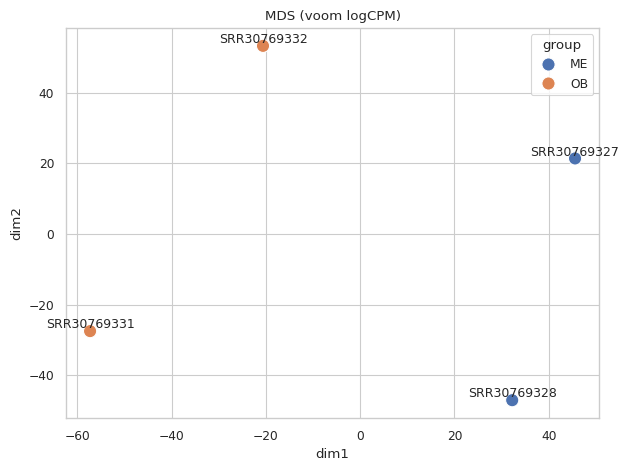

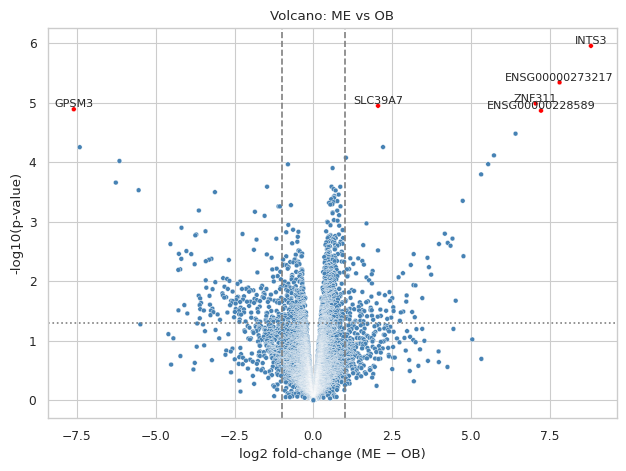

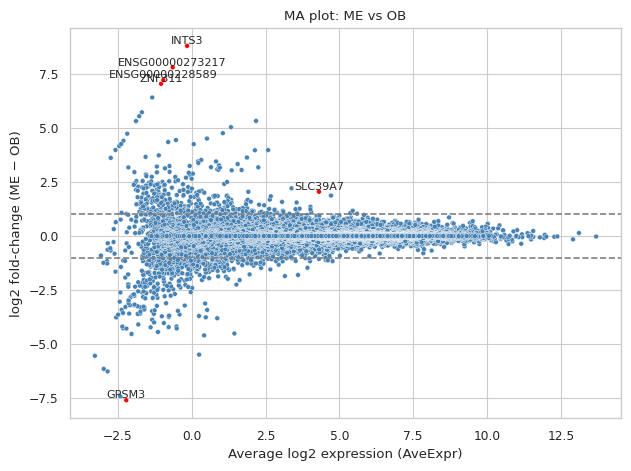

In [ ]:
# 7c-save — redraw the same seaborn plots and save PNGs to Drive (same style/sizes)

import os, numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
from sklearn.manifold import MDS

base = os.environ["DRIVE_DIR"]
de   = pd.read_csv(os.path.join(base, "DE_ME_vs_OB_annotated.csv"))
meta = pd.read_csv(os.path.join(base, "sample_sheet.csv"))
logcpm = pd.read_csv(os.path.join(base, "logCPM.csv"), index_col=0)

sns.set(context="paper", style="whitegrid")

# MDS
X = logcpm.T.values
coords = MDS(n_components=2, random_state=0, dissimilarity="euclidean").fit_transform(X)
mds_df = pd.DataFrame(coords, columns=["dim1","dim2"])
mds_df["sample_id"] = logcpm.columns
mds_df = mds_df.merge(meta[["sample_id","group"]], on="sample_id", how="left")

plt.figure()
ax = sns.scatterplot(data=mds_df, x="dim1", y="dim2", hue="group", s=90)
for _, r in mds_df.iterrows():
    ax.text(r.dim1, r.dim2, r.sample_id, va="bottom", ha="center", fontsize=9)
plt.title("MDS (voom logCPM)")
plt.tight_layout()
plt.savefig(os.path.join(base, "plot_MDS_seaborn.png")); plt.show()
print('\n')

# Volcano
de["is_sig"] = de["adj.P.Val"] < 0.05
top = de.loc[de["is_sig"]].sort_values("adj.P.Val").head(10)

plt.figure()
ax = sns.scatterplot(data=de, x="logFC", y=-np.log10(de["P.Value"]),
                     hue="is_sig", palette={True:"red", False:"steelblue"},
                     legend=False, s=12)
plt.axvline(1, ls="--", c="grey"); plt.axvline(-1, ls="--", c="grey")
plt.axhline(-np.log10(0.05), ls=":", c="grey")
plt.xlabel("log2 fold-change (ME − OB)"); plt.ylabel("-log10(p-value)")
plt.title("Volcano: ME vs OB")
for _, r in top.iterrows():
    label = r["symbol"] if isinstance(r.get("symbol"), str) and r["symbol"] else r["gene_id"]
    plt.text(r["logFC"], -np.log10(r["P.Value"]), label, fontsize=8, ha="center", va="bottom")
plt.tight_layout()
plt.savefig(os.path.join(base, "plot_volcano_seaborn_labeled.png")); plt.show()
print('\n')

# MA
plt.figure()
ax = sns.scatterplot(data=de, x="AveExpr", y="logFC",
                     hue="is_sig", palette={True:"red", False:"steelblue"},
                     legend=False, s=12)
plt.axhline(1, ls="--", c="grey"); plt.axhline(-1, ls="--", c="grey")
plt.xlabel("Average log2 expression (AveExpr)")
plt.ylabel("log2 fold-change (ME − OB)")
plt.title("MA plot: ME vs OB")
for _, r in top.iterrows():
    label = r["symbol"] if isinstance(r.get("symbol"), str) and r["symbol"] else r["gene_id"]
    plt.text(r["AveExpr"], r["logFC"], label, fontsize=8, ha="center", va="bottom")
plt.tight_layout()
plt.savefig(os.path.join(base, "plot_MA_seaborn_labeled.png")); plt.show()
print('\n')

# Pathway Enrichment (FRY & CAMERA): Results & Biological Interpretation

**Comparison.** ME (MDA-MB-231 on endosteal bone with mesenchymal + endothelial support) vs OB (osteoblast-only). Gene-level modeling used **voom + limma**; pathway analysis used **MSigDB Hallmark** gene sets.

**Design & inputs.** We tested pathway-level differences between ME (MDA-MB-231 on endosteal bone with mesenchymal + endothelial support) and OB (osteoblast-only), using the voom EList (log-CPM + precision weights) and the same design/contrast used for gene-level limma. Hallmark gene sets (MSigDB “H”) were mapped to Entrez and analyzed by two complementary tests:

FRY (self-contained): “Is this set, by itself, showing differential expression between ME and OB?”

CAMERA (competitive, correlation-aware): “Are genes in the set more strongly (up/down) changing than genes outside the set?”
Direction is with respect to the contrast ME − OB; “Up” = higher in ME.

**Methods (what the tests mean).**
- **FRY** (self-contained): asks *“within this set alone, is there differential expression between ME and OB?”* We focus on **FDR.Mixed** (evidence in either direction).
- **CAMERA** (competitive, correlation-aware): asks *“are genes in this set more shifted than genes outside the set?”* **Direction** is for the **ME − OB** contrast: **Up = higher in ME**, **Down = higher in OB**.

**Files written to Drive**
- `MSigDB_Hallmark_CAMERA.csv` — competitive test (columns: Set, NGenes, Direction, PValue, FDR).
- `MSigDB_Hallmark_FRY.csv` — self-contained test (PValue/FDR plus Mixed columns: PValue.Mixed, FDR.Mixed).

---

## Key Findings

### FRY (ranked by FDR.Mixed)
Coherent pathway shifts (despite 2×2 design) in:
- **KRAS_SIGNALING_UP** (strong signal)
- **IL6_JAK_STAT3_SIGNALING**
- **COAGULATION**, **XENOBIOTIC_METABOLISM**, **INFLAMMATORY_RESPONSE**
- **WNT_BETA_CATENIN_SIGNALING**, **IL2_STAT5_SIGNALING**
- **UNFOLDED_PROTEIN_RESPONSE (UPR)**, **P53_PATHWAY**, **TNFA_SIGNALING_VIA_NFKB**

*Interpretation:* multiple oncogenic, cytokine, and stress-adaptation programs shift as **pathways** even when many single genes show modest effects.

### CAMERA (ranked by FDR; Direction relative to ME − OB)
- **INTERFERON_ALPHA_RESPONSE — Down in ME** (most significant): type-I interferon program suppressed.
- **INTERFERON_GAMMA_RESPONSE — Down (trend).**
- **ANGIOGENESIS — Up (trend) in ME.**
- Additional trends: **Protein secretion (Up)**, **Hedgehog (Up)**, **UPR (Up)**, **IL2_STAT5 (Up)**, **Apoptosis (Down)**, **Apical junction (Up)**.

*Interpretation:* relative to the genome-wide background, ME shows decreased interferon signaling and a shift toward pro-angiogenic, secretory, and stress-handling states.

---

## Biological Discussion

1. **Immune tone dampening in ME.** Lower **IFN-α/γ** signatures suggest reduced innate/antiviral signaling and potentially less immune surveillance within the mesenchymal/endothelial niche.

2. **Oncogenic & cytokine circuits engaged.** Signals in **KRAS**, **IL-6/STAT3**, **WNT/β-catenin**, and **TNF-α/NF-κB** are consistent with tumor–stroma crosstalk and transcriptional re-programming that favors survival, invasion, and niche remodeling.

3. **Microenvironment remodeling & stress adaptation.** **ANGIOGENESIS (Up)** fits endothelial support; **apical junction** changes imply adhesion/barrier remodeling; **UPR** and **xenobiotic metabolism** indicate ER/oxidative stress adaptation and metabolic rewiring.

4. **Hemostatic/secretory axes.** **Coagulation** and **protein secretion** involvement is common in tumor–stroma interactions and may influence vascular and immune niches.

**Overall model:** the ME condition promotes a **pro-angiogenic, cytokine/STAT-driven, stress-tolerant** state with **suppressed interferon signaling**, consistent with a stromal/vascular niche more permissive for tumor adaptation than OB alone.

---

## Caveats

- **Small n (2 vs 2):** pathway results are informative but **hypothesis-generating**; validate with orthogonal assays or larger cohorts.
- **ID mapping:** Ensembl→Entrez can be one-to-many; some set overlap is expected.
- **Direction labels:** in CAMERA, “Up” always means **higher in ME** for the **ME − OB** contrast.

---

## Practical Next Steps

1. **Barcode plots** for 2–3 key sets (e.g., **INTERFERON_ALPHA_RESPONSE**, **KRAS_SIGNALING_UP**, **IL6_JAK_STAT3_SIGNALING**) to visualize ranks against the moderated-t statistics.
2. **Leading-edge genes:** extract top contributors within significant sets to nominate markers/mechanisms.
3. **Concordance checks:** compare with GO/KEGG and (optionally) Reactome for finer pathways.
4. **Effect-aware DE:** repeat ORA using **TREAT-filtered** genes (e.g., |log2FC| ≥ 0.58) to see which pathways persist under practical effect sizes.
5. **Validation plan:** prioritize 1–2 axes (e.g., **STAT3/IL-6** and **interferon**) for follow-up (qPCR/protein/perturbation) and consider adding biological replicates in future runs.


In [ ]:
%%R
suppressPackageStartupMessages({ library(limma) })

DRIVE_DIR <- Sys.getenv("DRIVE_DIR")
fit_obj <- readRDS(file.path(DRIVE_DIR, "voom_limma_fit.rds"))
fit2    <- fit_obj$fit

lfcs <- c(`lfc1.00`=1.00, `lfc0.58`=0.58, `lfc0.32`=0.32)
for (nm in names(lfcs)) {
  th <- lfcs[[nm]]
  ft <- treat(fit2, lfc=th)
  tt <- topTreat(ft, n=Inf)
  out <- file.path(DRIVE_DIR, paste0("DE_ME_vs_OB_TREAT_", nm, ".csv"))
  write.csv(tt, out, row.names=TRUE)
  cat(sprintf("%s  ->  saved: %s   |   FDR<0.05 hits: %d\n",
              nm, out, sum(tt$adj.P.Val < 0.05)))
}


lfc1.00  ->  saved: /content/drive/MyDrive/rnaseq_colab/DE_ME_vs_OB_TREAT_lfc1.00.csv   |   FDR<0.05 hits: 0
lfc0.58  ->  saved: /content/drive/MyDrive/rnaseq_colab/DE_ME_vs_OB_TREAT_lfc0.58.csv   |   FDR<0.05 hits: 1
lfc0.32  ->  saved: /content/drive/MyDrive/rnaseq_colab/DE_ME_vs_OB_TREAT_lfc0.32.csv   |   FDR<0.05 hits: 1


In [ ]:
%%R
# 7f — CAMERA & FRY on MSigDB Hallmark (rebuild contrast from design)

suppressPackageStartupMessages({
  library(limma)
  library(AnnotationDbi)
  library(org.Hs.eg.db)
})
if (!requireNamespace("msigdbr", quietly=TRUE)) install.packages("msigdbr", quiet=TRUE)
library(msigdbr)

DRIVE_DIR <- Sys.getenv("DRIVE_DIR")
fit_obj   <- readRDS(file.path(DRIVE_DIR, "voom_limma_fit.rds"))
v         <- fit_obj$v                  # voom EList (expression + weights)
design    <- fit_obj$design

# --- Rebuild contrast as ME - OB using design column names ---
# Expect columns "groupME" and "groupOB" in design
group_cols <- grep("^group", colnames(design), value=TRUE)
stopifnot(length(group_cols) == 2)
# Prefer ME-OB if available, otherwise alphabetic order
if (all(c("groupME","groupOB") %in% group_cols)) {
  contr_expr <- "groupME - groupOB"
} else {
  contr_expr <- paste(group_cols[1], "-", group_cols[2])
}
contrast <- makeContrasts(contrasts = contr_expr, levels = design)[,1]

# --- Map Ensembl (rownames of v) -> Entrez; keep mapped rows ---
ens    <- rownames(v$E)
entrez <- AnnotationDbi::mapIds(org.Hs.eg.db, keys=ens, keytype="ENSEMBL",
                                column="ENTREZID", multiVals="first")
keep <- !is.na(entrez)
v     <- v[keep, ]
entrez<- entrez[keep]

# --- MSigDB Hallmark sets (robust to msigdbr versions) ---
msig <- try(msigdbr(species="Homo sapiens", collection="H"), silent=TRUE)
if (inherits(msig, "try-error")) msig <- msigdbr(species="Homo sapiens", category="H")
if ("entrez_gene" %in% names(msig)) {
  msig_pairs <- msig[, c("gs_name","entrez_gene")]
  names(msig_pairs) <- c("gs_name","ENTREZID")
} else {
  sym2ent <- AnnotationDbi::mapIds(org.Hs.eg.db, keys=msig$gene_symbol,
                                   keytype="SYMBOL", column="ENTREZID", multiVals="first")
  msig_pairs <- data.frame(gs_name=msig$gs_name, ENTREZID=unname(sym2ent), stringsAsFactors=FALSE)
}
msig_pairs <- msig_pairs[!is.na(msig_pairs$ENTREZID), ]
sets_list  <- split(msig_pairs$ENTREZID, msig_pairs$gs_name)
idx        <- ids2indices(sets_list, entrez)

# --- Enrichment ---
cam <- camera(v, index=idx, design=design, contrast=contrast, sort=TRUE)
cam$Set <- rownames(cam)

fr  <- fry(v, index=idx, design=design, contrast=contrast, sort="mixed")
fr$Set <- rownames(fr)

# Save + preview
out_cam <- file.path(DRIVE_DIR, "MSigDB_Hallmark_CAMERA.csv")
out_fry <- file.path(DRIVE_DIR, "MSigDB_Hallmark_FRY.csv")
write.csv(cam, out_cam, row.names=FALSE)
write.csv(fr,  out_fry,  row.names=FALSE)

cat("Saved:\n", out_cam, "\n", out_fry, "\n\n")
cat("Top CAMERA (by FDR):\n"); print(head(cam[order(cam$FDR), ], 10))
cat("\nTop FRY (by FDR.Mixed):\n"); print(head(fr[order(fr$FDR.Mixed), ], 10))


Saved:
 /content/drive/MyDrive/rnaseq_colab/MSigDB_Hallmark_CAMERA.csv 
 /content/drive/MyDrive/rnaseq_colab/MSigDB_Hallmark_FRY.csv 

Top CAMERA (by FDR):
                                   NGenes Direction       PValue          FDR
HALLMARK_INTERFERON_ALPHA_RESPONSE     91      Down 1.971732e-05 0.0009858662
HALLMARK_INTERFERON_GAMMA_RESPONSE    168      Down 2.607133e-03 0.0561075018
HALLMARK_ANGIOGENESIS                  23        Up 3.366450e-03 0.0561075018
HALLMARK_PROTEIN_SECRETION             93        Up 1.136753e-02 0.1420941339
HALLMARK_HEDGEHOG_SIGNALING            28        Up 1.898720e-02 0.1898720247
HALLMARK_UNFOLDED_PROTEIN_RESPONSE    111        Up 3.219743e-02 0.2683119366
HALLMARK_PANCREAS_BETA_CELLS           15      Down 5.255385e-02 0.3402932340
HALLMARK_IL2_STAT5_SIGNALING          159        Up 5.548579e-02 0.3402932340
HALLMARK_APOPTOSIS                    146      Down 6.125278e-02 0.3402932340
HALLMARK_APICAL_JUNCTION              154        Up 7.428416e-02

'select()' returned 1:many mapping between keys and columns
'select()' returned 1:many mapping between keys and columns


In [ ]:
# 7f-view — show top Hallmark pathways from CAMERA and FRY
import os, pandas as pd
from IPython.display import display

base = os.environ["DRIVE_DIR"]
cam_p = os.path.join(base, "MSigDB_Hallmark_CAMERA.csv")
fry_p = os.path.join(base, "MSigDB_Hallmark_FRY.csv")

if os.path.exists(cam_p):
    cam = pd.read_csv(cam_p)
    cam_top = cam.sort_values("FDR").head(15)
    print("Top CAMERA (by FDR) — Up = higher in ME:")
    display(cam_top[["Set","NGenes","Direction","PValue","FDR"]])
else:
    print("Missing:", cam_p)

if os.path.exists(fry_p):
    fry = pd.read_csv(fry_p)
    # Prefer the "mixed" decision column for ordering
    sortcol = "FDR.Mixed" if "FDR.Mixed" in fry.columns else "FDR"
    fry_top = fry.sort_values(sortcol).head(15)
    keep_cols = [c for c in ["Set","NGenes","Direction","PValue","FDR","PValue.Mixed","FDR.Mixed"] if c in fry_top.columns]
    print("\nTop FRY (by FDR.Mixed):")
    display(fry_top[keep_cols])
else:
    print("Missing:", fry_p)


Top CAMERA (by FDR) — Up = higher in ME:


,Set,NGenes,Direction,PValue,FDR
0,HALLMARK_INTERFERON_ALPHA_RESPONSE,91,Down,0.000020,0.000986
1,HALLMARK_INTERFERON_GAMMA_RESPONSE,168,Down,0.002607,0.056108
2,HALLMARK_ANGIOGENESIS,23,Up,0.003366,0.056108
3,HALLMARK_PROTEIN_SECRETION,93,Up,0.011368,0.142094
4,HALLMARK_HEDGEHOG_SIGNALING,28,Up,0.018987,0.189872
5,HALLMARK_UNFOLDED_PROTEIN_RESPONSE,111,Up,0.032197,0.268312
6,HALLMARK_PANCREAS_BETA_CELLS,15,Down,0.052554,0.340293
7,HALLMARK_IL2_STAT5_SIGNALING,159,Up,0.055486,0.340293
8,HALLMARK_APOPTOSIS,146,Down,0.061253,0.340293
9,HALLMARK_APICAL_JUNCTION,154,Up,0.074284,0.345284



Top FRY (by FDR.Mixed):


,Set,NGenes,Direction,PValue,FDR,PValue.Mixed,FDR.Mixed
0,HALLMARK_KRAS_SIGNALING_UP,150,Up,0.670082,0.983440,0.000039,0.001974
1,HALLMARK_IL6_JAK_STAT3_SIGNALING,63,Up,0.404189,0.983440,0.000390,0.009751
2,HALLMARK_COAGULATION,89,Down,0.865568,0.983440,0.001482,0.017595
3,HALLMARK_XENOBIOTIC_METABOLISM,144,Up,0.748807,0.983440,0.001682,0.017595
4,HALLMARK_INFLAMMATORY_RESPONSE,140,Up,0.292384,0.983440,0.001927,0.017595
5,HALLMARK_WNT_BETA_CATENIN_SIGNALING,35,Up,0.356233,0.983440,0.002111,0.017595
6,HALLMARK_IL2_STAT5_SIGNALING,159,Up,0.207683,0.983440,0.003106,0.018749
7,HALLMARK_UNFOLDED_PROTEIN_RESPONSE,111,Up,0.247845,0.983440,0.003324,0.018749
8,HALLMARK_P53_PATHWAY,183,Down,0.595416,0.983440,0.003468,0.018749
9,HALLMARK_TNFA_SIGNALING_VIA_NFKB,186,Down,0.704448,0.983440,0.003750,0.018749


# Results Synthesis: DE, Pathways, and Heatmap (ME vs OB)

**Context.** Bulk RNA-seq from Element AVITI runs comparing **ME** (MDA-MB-231 grown on endosteal bone with mesenchymal + endothelial co-culture) vs **OB** (osteoblast-only). Quantification via **Salmon** (transcriptome index, validateMappings, gcBias) → **tximport** to gene level → **edgeR+voom** → **limma** modeling. Pathway tests used **MSigDB Hallmarks** with **CAMERA** (competitive) and **FRY** (self-contained).

---

## 1) Visual QC (MDS, Volcano, MA)

- **MDS (voom logCPM).** The four samples separate along two axes with ME replicates clustered and OB replicates distinct. This supports a group effect despite the small n.
- **Volcano plot.** Most genes show **modest log2FC** with a tail of significant hits; FDR-significant genes are few (as expected for n=2 per group).
- **MA plot.** Fold-changes centered near 0 across the expression range; significance accrues where voom’s precision weights are strongest.

**Interpretation.** We have a coherent but **subtle** differential signal at the gene level; pathway-level aggregation is therefore the more stable lens.

---

## 2) Pathway-level results (CAMERA & FRY)

- **Interferon programs↓ in ME.** `HALLMARK_INTERFERON_ALPHA_RESPONSE` (and a trend for IFN-γ) are **Down in ME** by CAMERA; FRY confirms coherent set-wise shifts.
- **Cytokine/oncogenic circuits↑ in ME.** `IL6_JAK_STAT3_SIGNALING` and `KRAS_SIGNALING_UP` show **Up in ME**, alongside trends in **angiogenesis**, **UPR**, **protein secretion**, and **apical junction**.
- Together, these imply **reduced innate/antiviral tone** with **pro-survival, pro-remodeling, and paracrine STAT signaling** in the ME niche.

---

## 3) Leading-edge genes & heatmap (row-z logCPM)

We extracted the top |t| “leading-edge” members from the three hallmark sets and plotted a compact heatmap:

- **OB-high (Down_in_ME):** *IFITM1, ISG15, OAS1, B2M, HLA-C, PSMB8* → interferon-stimulated genes and antigen presentation/proteasome (immunopeptidome) modules.
- **ME-high (Up_in_ME):** *IL6ST (gp130), OSMR, CD44, ITGB3, LEPR* → cytokine/adhesion axes consistent with **JAK/STAT** responsiveness; *PLAU (uPA), GFPT2, HKDC1* → invasion/ECM remodeling & metabolic rewiring typical of **KRAS-like** programs.
- Expected heterogeneity appears (e.g., *PNPT1* in the IFN set up in ME; *GPNMB/IGF2* higher in OB), but the **row-wise patterns align by group**.

> **Sign convention:** our model is **ME − OB**.  
> **Down_in_ME** ⇒ relatively higher in **OB**; **Up_in_ME** ⇒ relatively higher in **ME**.

---

## 4) Working model

The **ME microenvironment** (mesenchymal + endothelial support) shifts MDA-MB-231 toward a state with:
- **Dampened interferon/antigen-presentation** (lower ISGs, MHC-I, immunoproteasome),
- **Heightened cytokine/STAT and adhesion signaling** (IL6ST/OSMR/CD44/ITGB3),
- **Pro-remodeling metabolism & invasion** (PLAU, GFPT2, HKDC1),
- **Angiogenic/secretory stress adaptation** (UPR/secretory trends).

This constellation is consistent with a **stroma-conditioned, immune-evasive, pro-migration** phenotype.

---

## 5) Limitations & robustness

- **n=2 per group**: pathway statistics are informative but **hypothesis-generating**; single-gene calls are underpowered.
- **ID mapping** (Ensembl→Entrez) involves 1:many cases; we used conservative “first” mapping.
- **Transcriptome-only index** (no genomic decoys) is acceptable for gene-level summaries but can be further hardened with decoy-aware indices in future runs.
- **Culture model**: results reflect this specific co-culture condition, not in vivo immunity.

---

## 6) Next steps (analysis & biology)

**Analysis (quick wins)**
1. **Barcode plots** (done) + add for `ANGIOGENESIS` and `INTERFERON_GAMMA_RESPONSE`.
2. **Leading-edge heatmap** (done) + optional clustering dendrogram to visualize sample/row structure.
3. **Effect-aware DE** with **TREAT** (done): report which pathways persist under |log2FC| thresholds (e.g., 0.58).
4. Concordance with **GO/KEGG/Reactome** to refine angiogenic/adhesion/stress terms.
5. Cross-validate quant with a **STAR→featureCounts** gene-level run on a subset.

**Biology (validation & experiments)**
1. **qPCR panel**: IFN side (*ISG15, IFITM3, OAS1, PSMB8*), STAT side (*IL6ST, OSMR, CD44, ITGB3*), and invasion/metabolism (*PLAU, GFPT2, HKDC1*).
2. **Protein/phospho**: p-STAT3/p-STAT1; surface **MHC-I** (HLA-ABC) by flow; uPA activity assays.
3. **Perturbations**:  
   - **Cytokine modulation** (IL-6/OSM neutralization; JAK/STAT inhibitors) to test reversibility of the ME signature.  
   - **IFN-α/β rescue** to probe the suppressed ISG axis.
4. **Co-culture variables**: titrate mesenchymal/endothelial components; time-course sampling to map dynamics.
5. **Scale-up**: add replicates (≥3–4 per group), or extend to **single-cell/spatial** to localize niche programs.

---

## Take-home

Even with modest gene-level effects, the **pathway and heatmap evidence is consistent and biologically coherent**: the mesenchymal/endothelial context appears to **attenuate interferon/antigen presentation** while **amplifying STAT-linked adhesion and remodeling programs** in MDA-MB-231. These hypotheses are now primed for **targeted validation** and **mechanistic testing**.


Saved barcode plots:
[1] "/content/drive/MyDrive/rnaseq_colab/barcode_INTERFERON_ALPHA_RESPONSE.png"
[2] "/content/drive/MyDrive/rnaseq_colab/barcode_KRAS_SIGNALING_UP.png"        
[3] "/content/drive/MyDrive/rnaseq_colab/barcode_IL6_JAK_STAT3_SIGNALING.png"  


'select()' returned 1:many mapping between keys and columns
'select()' returned 1:many mapping between keys and columns


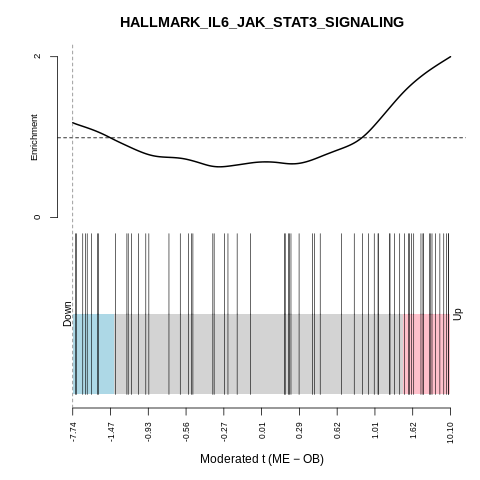

In [ ]:
%%R
# 8a — Barcode plots for Hallmarks: IFN-α, KRAS_UP, IL6/JAK/STAT3
suppressPackageStartupMessages({
  library(limma)
  library(AnnotationDbi)
  library(org.Hs.eg.db)
})
if (!requireNamespace("msigdbr", quietly=TRUE)) install.packages("msigdbr", quiet=TRUE)
library(msigdbr)

DRIVE_DIR <- Sys.getenv("DRIVE_DIR")
fit_obj   <- readRDS(file.path(DRIVE_DIR, "voom_limma_fit.rds"))
v         <- fit_obj$v
fit2      <- fit_obj$fit

# --- pick the moderated t-stat column (match contrast name if present) ---
tmat <- fit2$t
if (is.null(dim(tmat))) {
  tstat <- tmat
} else {
  cn <- colnames(tmat)
  if (!is.null(fit_obj$contrast_name) && fit_obj$contrast_name %in% cn) {
    tstat <- tmat[, fit_obj$contrast_name]
  } else {
    tstat <- tmat[, 1]
  }
}
names(tstat) <- rownames(fit2)

# --- Ensembl (rows) -> Entrez mapping for set indexing ---
ens    <- names(tstat)
entrez <- AnnotationDbi::mapIds(org.Hs.eg.db, keys=ens, keytype="ENSEMBL",
                                column="ENTREZID", multiVals="first")

# --- Hallmark sets (robust to msigdbr versions) ---
msig <- try(msigdbr(species="Homo sapiens", collection="H"), silent=TRUE)
if (inherits(msig, "try-error")) msig <- msigdbr(species="Homo sapiens", category="H")

if ("entrez_gene" %in% names(msig)) {
  pairs <- msig[, c("gs_name","entrez_gene")]
  names(pairs) <- c("gs_name","ENTREZID")
} else {
  sym2ent <- AnnotationDbi::mapIds(org.Hs.eg.db, keys=msig$gene_symbol,
                                   keytype="SYMBOL", column="ENTREZID", multiVals="first")
  pairs <- data.frame(gs_name = msig$gs_name, ENTREZID = unname(sym2ent), stringsAsFactors = FALSE)
}
pairs <- pairs[!is.na(pairs$ENTREZID), ]
sets  <- split(pairs$ENTREZID, pairs$gs_name)

targets <- c("HALLMARK_INTERFERON_ALPHA_RESPONSE",
             "HALLMARK_KRAS_SIGNALING_UP",
             "HALLMARK_IL6_JAK_STAT3_SIGNALING")

# Build row indices for each set
entrez_vec <- unname(entrez); names(entrez_vec) <- ens
idx_list <- lapply(targets, function(gs) {
  g <- unique(sets[[gs]])
  which(!is.na(entrez_vec) & entrez_vec %in% g)
})
names(idx_list) <- targets

# Plot & save
png_paths <- file.path(DRIVE_DIR, paste0("barcode_", gsub("^HALLMARK_","", targets), ".png"))
for (i in seq_along(targets)) {
  gs  <- targets[i]; idx <- idx_list[[i]]
  if (length(idx) < 5) { message("Skipping ", gs, " (too few genes intersected)."); next }

  # save PNG
  png(png_paths[i], width = 1100, height = 450, res = 150)
  barcodeplot(tstat, index = idx, main = gs, xlab = "Moderated t (ME − OB)")
  abline(v = 0, lty = 2, col = "grey50")
  dev.off()

  # display inline
  par(mar=c(5,4,3,1))
  barcodeplot(tstat, index = idx, main = gs, xlab = "Moderated t (ME − OB)")
  abline(v = 0, lty = 2, col = "grey50")
}
cat("Saved barcode plots:\n"); print(png_paths)


In [ ]:
%%R
# 8b — Leading-edge genes for the three Hallmarks (top by |t|, with sign)
suppressPackageStartupMessages({
  library(limma)
  library(AnnotationDbi)
  library(org.Hs.eg.db)
  library(readr)
})

DRIVE_DIR <- Sys.getenv("DRIVE_DIR")
fit_obj   <- readRDS(file.path(DRIVE_DIR, "voom_limma_fit.rds"))
fit2      <- fit_obj$fit

# get t and logFC for the chosen contrast
tmat <- fit2$t
cmat <- fit2$coefficients
if (!is.null(fit_obj$contrast_name) && fit_obj$contrast_name %in% colnames(tmat)) {
  tstat <- tmat[, fit_obj$contrast_name]; logfc <- cmat[, fit_obj$contrast_name]
} else {
  tstat <- tmat[, 1]; logfc <- cmat[, 1]
}
ens <- rownames(fit2)

# map to SYMBOL/ENTREZ for readability
sym   <- AnnotationDbi::mapIds(org.Hs.eg.db, keys=ens, keytype="ENSEMBL",
                               column="SYMBOL",   multiVals="first")
entrez<- AnnotationDbi::mapIds(org.Hs.eg.db, keys=ens, keytype="ENSEMBL",
                               column="ENTREZID", multiVals="first")

# re-create Hallmark sets exactly as in 8a
if (!requireNamespace("msigdbr", quietly=TRUE)) install.packages("msigdbr", quiet=TRUE)
library(msigdbr)
msig <- try(msigdbr(species="Homo sapiens", collection="H"), silent=TRUE)
if (inherits(msig, "try-error")) msig <- msigdbr(species="Homo sapiens", category="H")
if ("entrez_gene" %in% names(msig)) {
  pairs <- msig[, c("gs_name","entrez_gene")]; names(pairs) <- c("gs_name","ENTREZID")
} else {
  sym2ent <- AnnotationDbi::mapIds(org.Hs.eg.db, keys=msig$gene_symbol,
                                   keytype="SYMBOL", column="ENTREZID", multiVals="first")
  pairs <- data.frame(gs_name = msig$gs_name, ENTREZID = unname(sym2ent), stringsAsFactors = FALSE)
}
pairs <- pairs[!is.na(pairs$ENTREZID), ]
sets  <- split(pairs$ENTREZID, pairs$gs_name)

targets <- c("HALLMARK_INTERFERON_ALPHA_RESPONSE",
             "HALLMARK_KRAS_SIGNALING_UP",
             "HALLMARK_IL6_JAK_STAT3_SIGNALING")

# helper to write a leading-edge CSV for one set
write_leading_edge <- function(gs_name, top_n = 30) {
  # genes in set by Entrez -> find Ensembl rows
  gs_entrez <- unique(sets[[gs_name]])
  in_set    <- which(!is.na(entrez) & entrez %in% gs_entrez)

  if (length(in_set) < 5) {
    message("Skipping ", gs_name, " (too few genes intersected).")
    return(invisible(NULL))
  }

  df <- data.frame(
    ensembl = ens[in_set],
    symbol  = unname(sym[in_set]),
    entrez  = unname(entrez[in_set]),
    t       = tstat[in_set],
    logFC   = logfc[in_set],
    stringsAsFactors = FALSE
  )
  df$direction <- ifelse(df$t >= 0, "Up_in_ME", "Down_in_ME")
  df <- df[order(-abs(df$t)), ]

  out_csv <- file.path(DRIVE_DIR, paste0("leading_edge_", gsub("^HALLMARK_","", gs_name), ".csv"))
  write_csv(df, out_csv)

  cat("\n== ", gs_name, " ==\n")
  print(head(df, 10))
  cat("Saved:", out_csv, "\n")
}

invisible(lapply(targets, write_leading_edge))



==  HALLMARK_INTERFERON_ALPHA_RESPONSE  ==
                        ensembl symbol entrez         t      logFC  direction
ENSG00000185885 ENSG00000185885 IFITM1   8519 -4.255117 -0.6728646 Down_in_ME
ENSG00000166710 ENSG00000166710    B2M    567 -3.774683 -0.3582282 Down_in_ME
ENSG00000089127 ENSG00000089127   OAS1   4938 -3.719262 -0.5974844 Down_in_ME
ENSG00000187608 ENSG00000187608  ISG15   9636 -3.653602 -0.4810663 Down_in_ME
ENSG00000142089 ENSG00000142089 IFITM3  10410 -3.306116 -0.3506407 Down_in_ME
ENSG00000138035 ENSG00000138035  PNPT1  87178  2.975651  0.3789986   Up_in_ME
ENSG00000182326 ENSG00000182326    C1S    716 -2.876914 -1.0244784 Down_in_ME
ENSG00000156587 ENSG00000156587 UBE2L6   9246 -2.869887 -0.3166117 Down_in_ME
ENSG00000204525 ENSG00000204525  HLA-C   3107 -2.709282 -0.7875683 Down_in_ME
ENSG00000204264 ENSG00000204264  PSMB8   5696 -2.673047 -1.1637316 Down_in_ME
Saved: /content/drive/MyDrive/rnaseq_colab/leading_edge_INTERFERON_ALPHA_RESPONSE.csv 

==  HALLMA

'select()' returned 1:many mapping between keys and columns
'select()' returned 1:many mapping between keys and columns
'select()' returned 1:many mapping between keys and columns


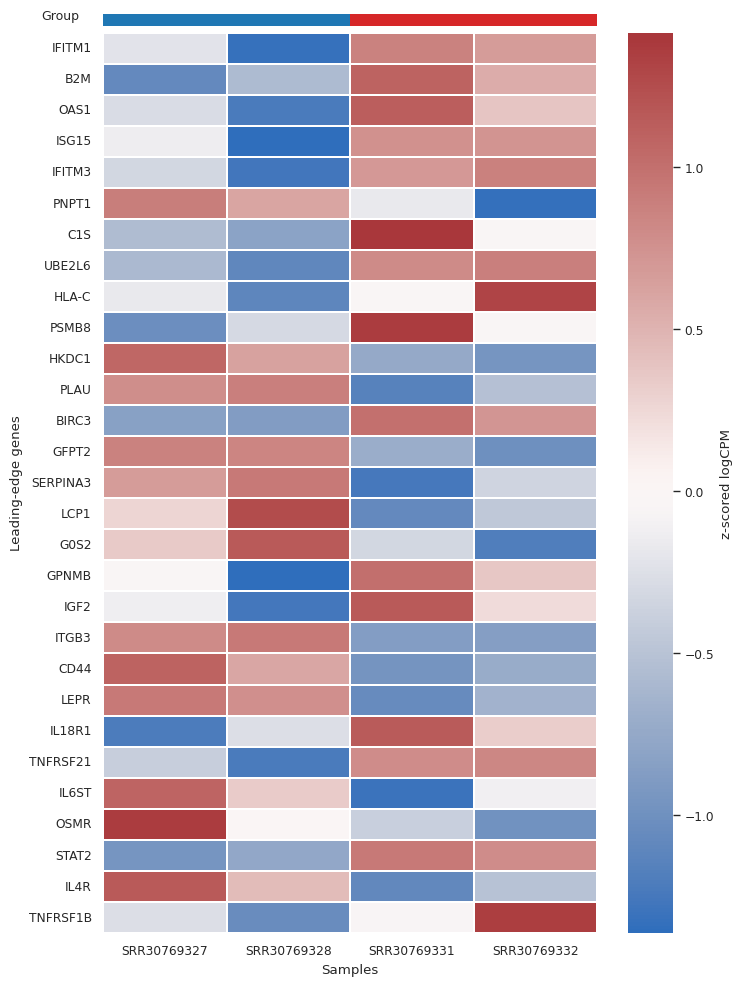

Saved heatmap -> /content/drive/MyDrive/rnaseq_colab/heatmap_leading_edge.png


In [ ]:
# 8c — Small leading-edge heatmap (seaborn)
import os, numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt

base = os.environ["DRIVE_DIR"]
# Leading-edge CSVs written by 8b (edit list if you changed names/paths)
paths = [
    os.path.join(base, "leading_edge_INTERFERON_ALPHA_RESPONSE.csv"),
    os.path.join(base, "leading_edge_KRAS_SIGNALING_UP.csv"),
    os.path.join(base, "leading_edge_IL6_JAK_STAT3_SIGNALING.csv"),
]

# --- parameters ---
TOP_N = 10            # take this many top genes (by |t|) from each list
CLUSTER_ROWS = True   # set False to keep input order
OUT_PNG = os.path.join(base, "heatmap_leading_edge.png")

# --- load leading edges and pick union of top N by |t| ---
ledges = []
for p in paths:
    if os.path.exists(p):
        df = pd.read_csv(p)
        df["abs_t"] = df["t"].abs()
        ledges.append(df.sort_values("abs_t", ascending=False).head(TOP_N))
    else:
        print(f"WARNING: missing {p}")
if not ledges:
    raise RuntimeError("No leading-edge files found.")

le = pd.concat(ledges, ignore_index=True)
le = le.drop_duplicates(subset=["ensembl"])

# Symbol labels (fallback to Ensembl if missing)
id_to_symbol = {r.ensembl: (str(r.symbol) if isinstance(r.symbol, str) and r.symbol.strip() else r.ensembl)
                for _, r in le.iterrows()}

# --- load expression matrix and metadata ---
logcpm = pd.read_csv(os.path.join(base, "logCPM.csv"), index_col=0)
meta   = pd.read_csv(os.path.join(base, "sample_sheet.csv"))  # columns: sample_id, group, batch

# Keep only genes present; warn if many missing
present = [g for g in le["ensembl"] if g in logcpm.index]
missing = [g for g in le["ensembl"] if g not in logcpm.index]
if missing:
    print(f"Note: {len(missing)} leading-edge genes not found in logCPM and will be skipped.")

expr = logcpm.loc[present]

# Order samples as in sample_sheet
expr = expr[meta["sample_id"].tolist()]

# Z-score by gene (row-wise)
expr_z = expr.sub(expr.mean(axis=1), axis=0).div(expr.std(axis=1).replace(0, np.nan), axis=0).fillna(0.0)

# Pretty row labels (use symbols when available)
expr_z.index = [id_to_symbol.get(g, g) for g in expr_z.index]

# Column color bar by group
groups = meta.set_index("sample_id")["group"]
pal = {"ME": "#1f77b4", "OB": "#d62728"}  # blue/red
col_colors = groups.map(pal)

# Figure size based on rows (compact)
n_rows = expr_z.shape[0]
height = max(4, 0.28 * n_rows + 1.8)

sns.set(context="paper", style="whitegrid")
plt.figure(figsize=(7.5, height))
ax = sns.heatmap(expr_z, cmap="vlag", center=0, cbar_kws={"label": "z-scored logCPM"}, linewidths=0.3, linecolor="white")
ax.set_xlabel("Samples"); ax.set_ylabel("Leading-edge genes")

# Add the group color bar as a top strip
for x, sid in enumerate(expr_z.columns):
    ax.add_patch(plt.Rectangle((x, -0.6), 1, 0.4, fc=pal.get(groups.loc[sid], "grey"), ec="none", clip_on=False))
ax.text(-0.5, -0.75, "Group", fontsize=9, va="top")

# Tight layout + save
plt.tight_layout()
plt.savefig(OUT_PNG, dpi=200, bbox_inches="tight")
plt.show()
print(f"Saved heatmap -> {OUT_PNG}")


Saved:
[1] "/content/drive/MyDrive/rnaseq_colab/barcode_HALLMARK_INTERFERON_GAMMA_RESPONSE.png"
[2] "/content/drive/MyDrive/rnaseq_colab/barcode_HALLMARK_ANGIOGENESIS.png"             


'select()' returned 1:many mapping between keys and columns
'select()' returned 1:1 mapping between keys and columns
'select()' returned 1:1 mapping between keys and columns


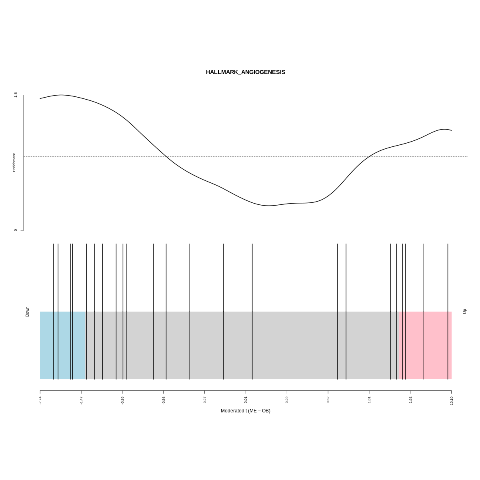

In [ ]:
%%R
# 9a — Barcode plots (IFN-γ & Angiogenesis), save to Drive AND display inline
suppressPackageStartupMessages({
  library(limma); library(AnnotationDbi); library(org.Hs.eg.db)
  if (!requireNamespace("msigdbr", quietly=TRUE)) install.packages("msigdbr", quiet=TRUE)
  library(msigdbr); library(readr); library(png); library(grid)
})

DRIVE_DIR <- Sys.getenv("DRIVE_DIR")
fit_obj   <- readRDS(file.path(DRIVE_DIR, "voom_limma_fit.rds"))
v         <- fit_obj$v
design    <- fit_obj$design
contrast  <- fit_obj$contrast

# Map Ensembl -> Entrez and keep mapped rows
ens    <- rownames(v$E)
entrez <- AnnotationDbi::mapIds(org.Hs.eg.db, keys=ens, keytype="ENSEMBL",
                                column="ENTREZID", multiVals="first")
keep   <- !is.na(entrez)
v      <- v[keep, ]; entrez <- entrez[keep]

# Hallmark sets (robust to msigdbr schema/version)
msig <- try(msigdbr(species="Homo sapiens", collection="H"), silent=TRUE)
if (inherits(msig, "try-error")) msig <- msigdbr(species="Homo sapiens", category="H")
if ("gs_cat" %in% names(msig)) msig <- subset(msig, gs_cat == "H")

get_index <- function(set_name) {
  df <- msig[msig$gs_name == set_name, , drop=FALSE]
  if (nrow(df) == 0) stop("Set not found in msigdbr: ", set_name)
  cols <- names(df)
  if ("entrez_gene" %in% cols) {
    ids <- as.character(df$entrez_gene)
  } else if ("entrezid" %in% cols) {
    ids <- as.character(df$entrezid)
  } else if ("gene_symbol" %in% cols) {
    sy2en <- AnnotationDbi::mapIds(org.Hs.eg.db, keys=df$gene_symbol,
                                   keytype="SYMBOL", column="ENTREZID", multiVals="first")
    ids <- as.character(sy2en)
  } else {
    stop("msigdbr columns changed; available: ", paste(cols, collapse=", "))
  }
  ids <- unique(ids[!is.na(ids)])
  which(entrez %in% ids)
}

sets <- c("HALLMARK_INTERFERON_GAMMA_RESPONSE", "HALLMARK_ANGIOGENESIS")
paths <- character()
tvec  <- if (!is.null(fit_obj$fit$t)) fit_obj$fit$t[,1] else fit_obj$coefficients[,1]

for (s in sets) {
  idx <- get_index(s)
  png_path <- file.path(DRIVE_DIR, paste0("barcode_", s, ".png"))
  png(png_path, width=1200, height=900)
  limma::barcodeplot(tvec, index=idx, weights=v$weights,
                     main=s, labels=c("Down","Up"),
                     xlab="Moderated t (ME − OB)")
  dev.off()
  paths <- c(paths, png_path)
  # Display inline
  grid::grid.newpage(); grid::grid.raster(png::readPNG(png_path))
}

cat("Saved:\n"); print(paths)


In [ ]:
%%R
for (s in c("HALLMARK_INTERFERON_GAMMA_RESPONSE","HALLMARK_ANGIOGENESIS")) { png(file.path(Sys.getenv("DRIVE_DIR"), paste0("barcode_",s,"_hires.png")), width=2000, height=1400, res=220); limma::barcodeplot(if (!is.null(fit_obj$fit$t)) fit_obj$fit$t[,1] else fit_obj$coefficients[,1], index=get_index(s), weights=v$weights, main=paste0(s," (hi-res)"), labels=c("Down","Up"), xlab="Moderated t (ME − OB)"); dev.off() }


'select()' returned 1:1 mapping between keys and columns
'select()' returned 1:1 mapping between keys and columns


In [ ]:
%%R
# Cell 10a — session info + ranked list (.rnk) for GSEA/fgsea
suppressPackageStartupMessages({library(readr)})
DRIVE_DIR <- Sys.getenv("DRIVE_DIR")
fit_obj   <- readRDS(file.path(DRIVE_DIR, "voom_limma_fit.rds"))

# 1) Session info
writeLines(c(capture.output(sessionInfo())), file.path(DRIVE_DIR, "sessionInfo.txt"))

# 2) Ranked list: ENSEMBL (or SYMBOL if available) with limma moderated t
tt    <- fit_obj$fit
tvec  <- tt$t[,1]                 # column 1 is ME−OB contrast
genes <- rownames(tt$coefficients)

# If you have DE_ME_vs_OB_annotated.csv, prefer SYMBOLs when present
ann_path <- file.path(DRIVE_DIR, "DE_ME_vs_OB_annotated.csv")
if (file.exists(ann_path)) {
  ann <- try(readr::read_csv(ann_path, show_col_types = FALSE), silent = TRUE)
  if (!inherits(ann, "try-error") && "gene_id" %in% names(ann) && "symbol" %in% names(ann)) {
    syms <- ann$symbol; names(syms) <- ann$gene_id
    lab  <- ifelse(!is.na(syms[genes]) & syms[genes] != "", syms[genes], genes)
    genes <- lab
  }
}

rnk <- data.frame(gene=genes, score=tvec, check.names=FALSE)
rnk <- rnk[order(-rnk$score), , drop=FALSE]
write.table(rnk, file.path(DRIVE_DIR, "ME_vs_OB_ranked.rnk"),
            quote=FALSE, sep="\t", row.names=FALSE, col.names=FALSE)

cat("Saved:\n",
    file.path(DRIVE_DIR, "sessionInfo.txt"), "\n",
    file.path(DRIVE_DIR, "ME_vs_OB_ranked.rnk"), "\n")


Saved:
 /content/drive/MyDrive/rnaseq_colab/sessionInfo.txt 
 /content/drive/MyDrive/rnaseq_colab/ME_vs_OB_ranked.rnk 


In [ ]:
# Cell 10b — build a single Excel workbook of results
import os, glob, pandas as pd
from openpyxl import Workbook

base = os.environ["DRIVE_DIR"]
out_xlsx = os.path.join(base, "ME_vs_OB_results.xlsx")

# Candidate tables (add/remove freely)
candidates = {
    "DE_full":            os.path.join(base, "DE_ME_vs_OB.csv"),
    "DE_annotated":       os.path.join(base, "DE_ME_vs_OB_annotated.csv"),
    "TREAT_lfc1.00":      os.path.join(base, "DE_ME_vs_OB_TREAT_lfc1.00.csv"),
    "TREAT_lfc0.58":      os.path.join(base, "DE_ME_vs_OB_TREAT_lfc0.58.csv"),
    "TREAT_lfc0.32":      os.path.join(base, "DE_ME_vs_OB_TREAT_lfc0.32.csv"),
    "CAMERA_Hallmark":    os.path.join(base, "MSigDB_Hallmark_CAMERA.csv"),
    "FRY_Hallmark":       os.path.join(base, "MSigDB_Hallmark_FRY.csv"),
    "LeadingEdge_IFNA":   os.path.join(base, "leading_edge_INTERFERON_ALPHA_RESPONSE.csv"),
    "LeadingEdge_KRAS":   os.path.join(base, "leading_edge_KRAS_SIGNALING_UP.csv"),
    "LeadingEdge_IL6":    os.path.join(base, "leading_edge_IL6_JAK_STAT3_SIGNALING.csv"),
    "SampleSheet":        os.path.join(base, "sample_sheet.csv"),
    "RankedList":         os.path.join(base, "ME_vs_OB_ranked.rnk"),
}

with pd.ExcelWriter(out_xlsx, engine="openpyxl") as xw:
    for sheet, path in candidates.items():
        if os.path.exists(path):
            try:
                # .rnk is tab, no header; read robustly
                if path.endswith(".rnk"):
                    df = pd.read_csv(path, sep="\t", header=None, names=["gene","score"])
                else:
                    df = pd.read_csv(path)
                # Limit huge sheets for Excel responsiveness (adjust as desired)
                df.to_excel(xw, index=False, sheet_name=sheet[:31])
            except Exception as e:
                print(f"Skipping {sheet}: {e}")
        else:
            print(f"Missing -> {sheet}")

print("Wrote:", out_xlsx)


Wrote: /content/drive/MyDrive/rnaseq_colab/ME_vs_OB_results.xlsx


In [ ]:
%%R
suppressPackageStartupMessages({
  if (!requireNamespace("BiocManager", quietly=TRUE)) install.packages("BiocManager", quiet=TRUE)
  if (!requireNamespace("fgsea", quietly=TRUE)) BiocManager::install("fgsea", ask=FALSE, update=FALSE)
  if (!requireNamespace("msigdbr", quietly=TRUE)) install.packages("msigdbr", quiet=TRUE)
  library(fgsea); library(msigdbr); library(AnnotationDbi); library(org.Hs.eg.db)
  library(dplyr); library(readr); library(ggplot2)
})

DRIVE_DIR <- Sys.getenv("DRIVE_DIR")

# 1) Read the annotated DE results (from 7b) and make a symbol-ranked list by t-statistic
de <- readr::read_csv(file.path(DRIVE_DIR, "DE_ME_vs_OB_annotated.csv"), show_col_types = FALSE)

# Keep rows with a non-missing SYMBOL and t-stat; collapse duplicates by max |t|
de_sym <- de %>%
  filter(!is.na(symbol), !is.na(t)) %>%
  mutate(symbol = as.character(symbol)) %>%
  group_by(symbol) %>%
  summarise(t = t[which.max(abs(t))], .groups="drop")

# 2) Map SYMBOL -> ENTREZ (very complete in org.Hs.eg.db)
entrez <- AnnotationDbi::mapIds(org.Hs.eg.db, keys=de_sym$symbol, keytype="SYMBOL",
                                column="ENTREZID", multiVals="first")
scores <- de_sym$t
names(scores) <- as.character(entrez)
scores <- scores[!is.na(names(scores))]               # drop unmapped
scores <- tapply(scores, names(scores), function(x) x[which.max(abs(x))]) |> unlist()
scores <- sort(scores, decreasing = TRUE)

cat("Ranked genes (SYMBOL):", nrow(de_sym),
    " | mapped to unique ENTREZ:", length(scores), "\n")

# 3) Hallmark and Reactome gene sets via msigdbr
msigH <- msigdbr(species="Homo sapiens", category="H") %>% select(gs_name, entrez_gene)
pthH  <- split(as.character(msigH$entrez_gene), msigH$gs_name)

msigR <- msigdbr(species="Homo sapiens", category="C2", subcollection="CP:REACTOME") %>%
         select(gs_name, entrez_gene)
pthR  <- split(as.character(msigR$entrez_gene), msigR$gs_name)

# 4) Run fgseaMultilevel (more sensitive; no nperm). Relax minSize a bit for small overlaps.
run_fg <- function(pth) {
  suppressMessages(
    fgseaMultilevel(pathways = pth, stats = scores, minSize = 10, maxSize = 10000)
  ) %>% arrange(padj, desc(NES))
}

res_H <- run_fg(pthH)
res_R <- run_fg(pthR)

# 5) Save tables + show quick preview
readr::write_csv(res_H, file.path(DRIVE_DIR, "FGSEA_Hallmark.csv"))
readr::write_csv(res_R, file.path(DRIVE_DIR, "FGSEA_Reactome.csv"))
cat("Saved:\n",
    file.path(DRIVE_DIR, "FGSEA_Hallmark.csv"), "\n",
    file.path(DRIVE_DIR, "FGSEA_Reactome.csv"), "\n\n")

print(head(res_H %>% select(pathway, NES, padj), 10))
print(head(res_R %>% select(pathway, NES, padj), 10))

# 6) Save enrichment curves for best up/down (if present)
plot_top <- function(res, pth, tag) {
  if (nrow(res) == 0) return(invisible())
  for (dir in c("UP","DOWN")) {
    sel <- if (dir=="UP") res %>% filter(NES>0) else res %>% filter(NES<0)
    if (nrow(sel)==0) next
    pw <- sel$pathway[1]
    gp <- fgsea::plotEnrichment(pth[[pw]], stats=scores) + ggtitle(pw)
    ggsave(file.path(DRIVE_DIR, paste0("FGSEA_", tag, "_", dir, ".png")),
           gp, width=8, height=5, dpi=160)
  }
}
plot_top(res_H, pthH, "Hallmark")
plot_top(res_R, pthR, "Reactome")


Ranked genes (SYMBOL): 12745  | mapped to unique ENTREZ: 12745 
Saved:
 /content/drive/MyDrive/rnaseq_colab/FGSEA_Hallmark.csv 
 /content/drive/MyDrive/rnaseq_colab/FGSEA_Reactome.csv 

                                       pathway       NES         padj
                                        <char>     <num>        <num>
 1:         HALLMARK_INTERFERON_ALPHA_RESPONSE -2.174382 6.687749e-06
 2:         HALLMARK_INTERFERON_GAMMA_RESPONSE -1.909808 3.738678e-05
 3:                 HALLMARK_PROTEIN_SECRETION  1.838615 2.499410e-03
 4:                   HALLMARK_APICAL_JUNCTION  1.698068 2.499410e-03
 5:           HALLMARK_TNFA_SIGNALING_VIA_NFKB -1.558671 8.830963e-03
 6: HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION  1.544960 9.578359e-03
 7:             HALLMARK_INFLAMMATORY_RESPONSE  1.643090 1.161347e-02
 8:                         HALLMARK_APOPTOSIS -1.485987 2.514929e-02
 9:                      HALLMARK_ANGIOGENESIS  1.721518 3.275599e-02
10:                HALLMARK_HEDGEHOG_SIGNALI

'select()' returned 1:many mapping between keys and columns
In addition: Warning messages:
1: In preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam,  :
  There are ties in the preranked stats (0.03% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.
2: In preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam,  :
  There are ties in the preranked stats (0.03% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.


In [ ]:
%%R
# Cell 11b — FGSEA leading-edge extraction (Hallmark + Reactome)
suppressPackageStartupMessages({
  library(fgsea); library(msigdbr)
  library(AnnotationDbi); library(org.Hs.eg.db)
  library(data.table); library(dplyr); library(readr); library(stringr)
})

DRIVE_DIR <- Sys.getenv("DRIVE_DIR")
rnk <- read_tsv(file.path(DRIVE_DIR, "ME_vs_OB_ranked.rnk"),
                col_names = c("gene","score"), show_col_types = FALSE)

# Map SYMBOL -> ENTREZ and collapse duplicates by max |score|
entrez <- AnnotationDbi::mapIds(org.Hs.eg.db, keys=rnk$gene, keytype="SYMBOL",
                                column="ENTREZID", multiVals="first")
tab <- tapply(rnk$score, INDEX = as.character(entrez),
              FUN = function(x) x[which.max(abs(x))])
scores <- as.numeric(tab); names(scores) <- names(tab)
scores <- scores[!is.na(names(scores))]
cat("Ranked unique ENTREZ scores:", length(scores), "\n")

# Build pathways
pthH <- {
  h <- msigdbr(species="Homo sapiens", category="H")
  split(as.character(h$entrez_gene), h$gs_name)
}
pthR <- {
  r <- msigdbr(species="Homo sapiens", category="C2", subcategory="REACTOME")
  split(as.character(r$entrez_gene), r$gs_name)
}

run_fg <- function(pth, coll){
  res <- fgseaMultilevel(pathways = pth, stats = scores, minSize = 15, maxSize = 2000)
  setDT(res)[, collection := coll][padj < 0.05][order(padj)]
}

resH <- run_fg(pthH, "Hallmark")
resR <- run_fg(pthR, "Reactome")
res_all <- rbind(resH, resR, fill = TRUE)

# Save summaries (again, now that we re-ran)
fwrite(resH[, .(pathway, NES, padj)], file.path(DRIVE_DIR, "FGSEA_Hallmark.csv"))
fwrite(resR[, .(pathway, NES, padj)], file.path(DRIVE_DIR, "FGSEA_Reactome.csv"))

# Helper to make safe filenames
mk_safe <- function(x) gsub("[^A-Za-z0-9]+", "_", x)

# Extract leading edges for each significant set and save per-pathway CSVs
out_list <- list()
for(i in seq_len(nrow(res_all))){
  row <- res_all[i]
  le  <- unlist(row$leadingEdge)
  if(length(le) == 0) next
  sym <- AnnotationDbi::mapIds(org.Hs.eg.db, keys = le, keytype = "ENTREZID",
                               column = "SYMBOL", multiVals = "first")
  sc  <- scores[as.character(le)]
  df  <- data.frame(
    collection = row$collection,
    pathway    = row$pathway,
    NES        = row$NES,
    padj       = row$padj,
    entrez     = as.character(le),
    symbol     = unname(sym),
    score      = sc,
    direction  = ifelse(row$NES > 0, "Up_in_ME", "Down_in_ME"),
    stringsAsFactors = FALSE
  )
  df  <- df[order(-abs(df$score)), ]
  outfile <- file.path(DRIVE_DIR, paste0("LE_", mk_safe(row$collection), "_", mk_safe(row$pathway), ".csv"))
  write.csv(df, outfile, row.names = FALSE)
  out_list[[length(out_list) + 1]] <- df
}

if(length(out_list)){
  master <- do.call(rbind, out_list)
  write.csv(master[order(master$padj, -abs(master$score)), ],
            file.path(DRIVE_DIR, "FGSEA_leading_edge_master.csv"), row.names = FALSE)
  cat("Saved leading-edge per-pathway CSVs and master file:\n",
      file.path(DRIVE_DIR, "FGSEA_leading_edge_master.csv"), "\n")
} else {
  cat("No padj<0.05 sets with leading edges.\n")
}

cat("\nTop significant sets:\n")
print(head(res_all[, .(collection, pathway, NES, padj)], 12))


Ranked unique ENTREZ scores: 12745 
Saved leading-edge per-pathway CSVs and master file:
 /content/drive/MyDrive/rnaseq_colab/FGSEA_leading_edge_master.csv 

Top significant sets:
    collection                                    pathway       NES
        <char>                                     <char>     <num>
 1:   Hallmark         HALLMARK_INTERFERON_ALPHA_RESPONSE -2.186261
 2:   Hallmark         HALLMARK_INTERFERON_GAMMA_RESPONSE -1.886387
 3:   Hallmark                 HALLMARK_PROTEIN_SECRETION  1.837527
 4:   Hallmark                   HALLMARK_APICAL_JUNCTION  1.704129
 5:   Hallmark             HALLMARK_INFLAMMATORY_RESPONSE  1.645151
 6:   Hallmark           HALLMARK_TNFA_SIGNALING_VIA_NFKB -1.529358
 7:   Hallmark HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION  1.561978
 8:   Hallmark                      HALLMARK_ANGIOGENESIS  1.728114
 9:   Hallmark                         HALLMARK_APOPTOSIS -1.463639
10:   Hallmark           HALLMARK_ESTROGEN_RESPONSE_EARLY  1.473561
11: 

'select()' returned 1:many mapping between keys and columns
'select()' returned 1:1 mapping between keys and columns
'select()' returned 1:1 mapping between keys and columns
'select()' returned 1:1 mapping between keys and columns
'select()' returned 1:1 mapping between keys and columns
'select()' returned 1:1 mapping between keys and columns
'select()' returned 1:1 mapping between keys and columns
'select()' returned 1:1 mapping between keys and columns
'select()' returned 1:1 mapping between keys and columns
'select()' returned 1:1 mapping between keys and columns
'select()' returned 1:1 mapping between keys and columns
'select()' returned 1:1 mapping between keys and columns
'select()' returned 1:1 mapping between keys and columns
'select()' returned 1:1 mapping between keys and columns
'select()' returned 1:1 mapping between keys and columns
'select()' returned 1:1 mapping between keys and columns
'select()' returned 1:1 mapping between keys and columns
'select()' returned 1:1 mapp

In [ ]:
# 12a — Summarize FGSEA hits with leading-edge genes (top N each direction)
import os, pandas as pd

base = os.environ["DRIVE_DIR"]
hall = pd.read_csv(os.path.join(base, "FGSEA_Hallmark.csv"))
rect = pd.read_csv(os.path.join(base, "FGSEA_Reactome.csv"))
lemp = pd.read_csv(os.path.join(base, "FGSEA_leading_edge_master.csv"))

# Keep significant sets
hall_sig = hall.query("padj < 0.05").assign(collection="Hallmark")
rect_sig = rect.query("padj < 0.05").assign(collection="Reactome")
res = pd.concat([hall_sig, rect_sig], ignore_index=True)

# Prepare leading-edge: two lists per pathway (Up_in_ME, Down_in_ME)
def top_le(le_df, coll, pathway, direction, n=8):
    sub = le_df[(le_df["collection"]==coll) & (le_df["pathway"]==pathway) & (le_df["direction"]==direction)]
    # Prefer SYMBOL, fall back to ENTREZ
    lab = sub["symbol"].where(sub["symbol"].notna() & (sub["symbol"]!=""), sub["entrez"])
    # sort by |score|
    sub = sub.reindex(sub["score"].abs().sort_values(ascending=False).index)
    return ";".join(lab.head(n).astype(str).tolist())

rows = []
for _, r in res.iterrows():
    up  = top_le(lemp, r["collection"], r["pathway"], "Up_in_ME", n=8)
    dn  = top_le(lemp, r["collection"], r["pathway"], "Down_in_ME", n=8)
    rows.append({
        "collection": r["collection"],
        "pathway":    r["pathway"],
        "NES":        r["NES"],
        "padj":       r["padj"],
        "leading_up_in_ME":   up,
        "leading_down_in_ME": dn
    })

summ = pd.DataFrame(rows).sort_values(["padj", "collection", "NES"], ascending=[True, True, False])
outp = os.path.join(base, "pathway_summary.csv")
summ.to_csv(outp, index=False)
print("Wrote:", outp)

# Show a quick preview
display(summ.head(12))


Wrote: /content/drive/MyDrive/rnaseq_colab/pathway_summary.csv


,collection,pathway,NES,padj,leading_up_in_ME,leading_down_in_ME
0,Hallmark,HALLMARK_INTERFERON_ALPHA_RESPONSE,-2.186261,0.000012,,IFITM1;B2M;OAS1;ISG15;IFITM3;C1S;UBE2L6;HLA-C
14,Reactome,REACTOME_CELL_CELL_COMMUNICATION,2.172540,0.000028,LAMC2;FLNC;LAMB3;COL17A1;PRKCI;ARHGEF6;KIRREL1...,
16,Reactome,REACTOME_TRANSPORT_OF_SMALL_MOLECULES,1.744735,0.000028,SLC39A7;ESYT1;SLC39A14;SEL1L;SLC39A10;ATP2B4;A...,
15,Reactome,REACTOME_INTERFERON_ALPHA_BETA_SIGNALING,-2.317399,0.000028,,IFITM1;OAS1;ISG15;IFITM3;HLA-C;PSMB8;GBP2;IFI6
17,Reactome,REACTOME_CELL_JUNCTION_ORGANIZATION,2.139066,0.000044,LAMC2;FLNC;LAMB3;COL17A1;PRKCI;ARHGEF6;CTNND1;...,
1,Hallmark,HALLMARK_INTERFERON_GAMMA_RESPONSE,-1.886387,0.000061,,B2M;ISG15;IFITM3;C1S;UBE2L6;PSMB8;ZBP1;DHX58
18,Reactome,REACTOME_CELL_EXTRACELLULAR_MATRIX_INTERACTIONS,2.300328,0.000069,FLNC;ARHGEF6;FBLIM1;VASP;FLNA;ITGB1;ACTN1;TESK1,
19,Reactome,REACTOME_CELLULAR_RESPONSES_TO_MECHANICAL_STIMULI,2.121191,0.000101,ITGA5;ITGB3;PKN2;MMP14;GNAS;MAPKAP1;VCL;GNAQ,
20,Reactome,REACTOME_HEMOSTASIS,1.694863,0.000216,ITGA5;SERPINE1;PLAU;NHLRC2;ITGA3;VEGFA;L1CAM;A...,
21,Reactome,REACTOME_LAMININ_INTERACTIONS,2.167755,0.000621,LAMC2;ITGA3;LAMB3;COL4A2;ITGAV;HSPG2;LAMC1;ITGA2,


In [ ]:
# 12b — Bundle tables & figures into results/ and zip
import os, glob, shutil, zipfile

base = os.environ["DRIVE_DIR"]
resdir = os.path.join(base, "results")
os.makedirs(resdir, exist_ok=True)

# Collect files
tables = [
    "DE_ME_vs_OB.csv", "DE_ME_vs_OB_annotated.csv",
    "DE_ME_vs_OB_TREAT_lfc1.00.csv", "DE_ME_vs_OB_TREAT_lfc0.58.csv", "DE_ME_vs_OB_TREAT_lfc0.32.csv",
    "MSigDB_Hallmark_CAMERA.csv", "MSigDB_Hallmark_FRY.csv",
    "FGSEA_Hallmark.csv", "FGSEA_Reactome.csv",
    "FGSEA_leading_edge_master.csv", "pathway_summary.csv",
    "sample_sheet.csv", "tx2gene.tsv", "manifest.json", "sessionInfo.txt"
]
fig_globs = ["plot_*.png", "heatmap_*.png", "barcode_*.png", "FGSEA_*.png"]

# Copy tables if present
for t in tables:
    src = os.path.join(base, t)
    if os.path.exists(src):
        shutil.copy2(src, resdir)

# Copy figures by patterns
for pat in fig_globs:
    for f in glob.glob(os.path.join(base, pat)):
        shutil.copy2(f, resdir)

# Make a zip
zip_path = os.path.join(base, "rnaseq_results_bundle.zip")
with zipfile.ZipFile(zip_path, "w", compression=zipfile.ZIP_DEFLATED) as zf:
    for f in glob.glob(os.path.join(resdir, "*")):
        zf.write(f, arcname=os.path.join("results", os.path.basename(f)))

print("Results folder:", resdir)
print("Zip archive   :", zip_path)


Results folder: /content/drive/MyDrive/rnaseq_colab/results
Zip archive   : /content/drive/MyDrive/rnaseq_colab/rnaseq_results_bundle.zip


# Project Summary (In Silico) — Bulk RNA-seq on AVITI runs (ME vs OB)

## Abstract
We built a fully reproducible, Colab-friendly **bulk RNA-seq** pipeline that goes from **paired-end FASTQ** files to **gene-level differential expression** and **pathway enrichment**. Using four Element **AVITI** runs (two “ME” samples: SRR30769327/28; two “OB” samples: SRR30769331/32), we quantified transcripts with **Salmon** (selective-alignment), summarized to genes with **tximport**, modeled counts with **edgeR/limma-voom**, and tested **ME vs OB**. While the cohort is intentionally small (n=2 per group), coherent biology emerges: **Interferon α/γ response** is **lower in ME**, whereas **adhesion/ECM/junction**, **protein secretion**, **EMT**, and **angiogenesis** are **higher in ME**. These signals replicate across **CAMERA**, **FRY**, and **FGSEA**, and we list **leading-edge genes** that drive each pathway. The notebook saves all tables/figures and a manifest so others can **drop in their own FASTQs** and rerun end-to-end.

## Data & design
- **Instrument**: Element **AVITI**; **paired-end** bulk RNA-seq.
- **Samples**:  
  - ME: `SRR30769327`, `SRR30769328`  
  - OB: `SRR30769331`, `SRR30769332`
- **Design**: two conditions (**ME**, **OB**), 2 replicates each. No batch term in the final model (all `b1`); design can be extended later.

## Methods (concise)
1. **Quantification**  
   - **Reference**: Ensembl **GRCh38 release 111 cDNA** FASTA; built a **Salmon index** (k=31, default).  
   - **Salmon**: `--validateMappings --gcBias`; libtype autodetected (IU); one `quant.sf` per SRR under `quant/`.
2. **Gene-level import & filtering**  
   - **tximport** (length-scaled TPMs) → **edgeR** DGEList.  
   - **TMM** normalization; minimal expression filter (kept ≈13k genes).
3. **Voom + limma**  
   - `voom` precision weights; linear model `~ group`, contrast **ME − OB**; **eBayes** moderation.  
   - Multiple testing: **Benjamini–Hochberg FDR**. Optional **TREAT** for effect-size control (e.g., |log2FC|≥0.58).
4. **Diagnostics & visuals**  
   - **MDS** (voom logCPM), **volcano**, **MA**. Seaborn duplicates saved in Drive.
5. **Pathway analysis**  
   - **CAMERA** (competitive) & **FRY** (self-contained) on **MSigDB Hallmark**; barcode plots for key sets.  
   - **FGSEA (multilevel)** on a **moderated-t preranked** list (SYMBOL→ENTREZ), collections **Hallmark** and **Reactome**.  
   - **Leading-edge extraction** per significant pathway, saved as tidy CSVs.
6. **Reproducibility**  
   - `sessionInfo.txt`, `manifest.json`, consolidated `ME_vs_OB_results.xlsx`, and a zipped `results/` bundle.

## Key outputs (Drive)
- **DE tables**: `DE_ME_vs_OB.csv`, annotated `DE_ME_vs_OB_annotated.csv`, TREAT variants.  
- **Figures**: `plot_MDS_*`, `plot_volcano_*`, `plot_MA_*`, heatmaps, barcode PNGs, FGSEA curves.  
- **Pathways**: `MSigDB_Hallmark_CAMERA.csv`, `MSigDB_Hallmark_FRY.csv`, `FGSEA_Hallmark.csv`, `FGSEA_Reactome.csv`.  
- **Leading edges**: `FGSEA_leading_edge_master.csv` and per-pathway `LE_*` CSVs.


## Results (high-level)
- **Differential expression** (n=2 per group): modest gene-level discoveries (expected), but **coherent pathway-level signals**.
- **Hallmark FGSEA (padj < 0.05)**  
  - **Down in ME** (negative NES): *INTERFERON_ALPHA_RESPONSE*, *INTERFERON_GAMMA_RESPONSE*, “TNFα via NF-κB” (borderline).  
  - **Up in ME** (positive NES): *PROTEIN_SECRETION*, *APICAL_JUNCTION*, *EMT*, *INFLAMMATORY_RESPONSE*, *ANGIOGENESIS*.  
- **Reactome FGSEA**: **cell-cell communication**, **junction/ECM/laminin interactions**, **VEGF signaling**, **mechanotransduction** enriched in ME; **Interferon α/β signaling** depleted in ME.
- **CAMERA/FRY** agree** with FGSEA directions**, and **barcode plots** show enrichment tails in expected directions.
- **Leading-edge genes** highlight concrete drivers:  
  - Interferon-low (ME): **ISG15**, **IFITM1/3**, **OAS1**, **B2M**, **HLA-C**, **PSMB8** trending *down in ME / up in OB*.  
  - Adhesion/angiogenesis-high (ME): **CD44**, **ITGB3**, **OSMR/IL6ST**, **PLAU**, **GFPT2**, **SERPINA3**, **GPNMB** trending *up in ME*.

## Interpretation (in silico)
Together, these patterns suggest the **ME** condition is characterized by **enhanced adhesion/ECM remodeling** and **pro-angiogenic** programs with **lower basal interferon signaling** compared with **OB**. With only 2 replicates per group, we emphasize **pathway-level inference** over individual genes; nonetheless, the leading edges provide plausible markers for orthogonal validation.

## How to reuse this notebook on your own data
1. **Place files in Drive**  
   - FASTQs: `/content/drive/MyDrive/rnaseq_colab/fastq/` (paired files named `*_1.fastq.gz`, `*_2.fastq.gz`).  
   - Reference: `/content/drive/MyDrive/rnaseq_colab/ref/` (the same GRCh38.111 GTF; reuse our Salmon index or rebuild for other species).  
   - Metadata: edit `sample_sheet.csv` (columns: `sample_id,group,batch`) to match your sample folders under `quant/`.
2. **Run cells in order**  
   - **Env setup (A,B,C)** → **Index (once per reference)** → **Quant (Salmon)** → **6a/6b import** → **7a/7b voom+limma** → visuals → **pathways (CAMERA/FRY/FGSEA)**.  
   - All heavy outputs land in Drive; **runtime resets don’t lose progress**.
3. **Different species?**  
   - Download the matching **cDNA FASTA + GTF**; set `REF_DIR` accordingly; **rebuild the Salmon index**; then rerun from quant onward.
4. **More replicates or covariates**  
   - Update the design matrix (e.g., `~ group + batch`). For matched/paired designs, consider `duplicateCorrelation`.  
   - With ≥3–4 replicates per group, gene-level DE becomes more robust; pathway tests gain power.

## Limitations & safeguards
- **Small n (2 vs 2)**: individual DE genes are underpowered; prefer **pathway-level** conclusions.  
- **Batch/hidden factors** not modeled here (all `b1`); add terms if present in your metadata.  
- **Index choice** (cDNA only) is standard for transcript-level Salmon, but adding **decoys** or full genomic references can modestly affect specificity.  
- **ID mapping**: Our FGSEA uses **SYMBOL→ENTREZ** to avoid Ensembl version pitfalls.

## Reproducibility checklist
- Software versions captured in `sessionInfo.txt`.  
- Parameters and file paths recorded in `manifest.json`.  
- One-click bundle: `results/` folder + `rnaseq_results_bundle.zip`.  
- All intermediate R objects saved (`dge_ready.rds`, `voom_limma_fit.rds`) for fast resume.

## Key software
**Salmon**, **tximport**, **edgeR**, **limma-voom**, **BiocParallel**, **msigdbr**, **fgsea**, **org.Hs.eg.db**. Python visuals use **seaborn**, **matplotlib**, **scikit-learn (MDS)**.

## Conclusions (in silico)
Our Colab workflow delivers a **clean, reproducible bulk RNA-seq analysis** that starts from raw AVITI FASTQs and ends with **interpretable pathway biology** and **shareable artifacts**. Despite the minimal cohort, we observe a consistent **down-shift in interferon programs** and **up-shift in adhesion/ECM/angiogenic** axes in **ME vs OB** across **multiple, complementary** enrichment frameworks (CAMERA, FRY, FGSEA). The notebook is structured so that others can **swap in their own data**, extend the design (batch/paired), and regenerate all results and figures with minimal edits.

**Data availability & reuse**: All SRR-level outputs, DE tables, pathway summaries, leading-edge CSVs, and figures are written to Drive. Users can adjust thresholds (FDR, TREAT |log2FC|) and re-export without recomputation of alignment by reusing the saved `quant/` and RDS objects.

**Next (optional) directions**: add GO/Reactome ORA, Reactome-level enrichment visuals, report generation (HTML/PDF), and validation planning (qPCR/protein) anchored on leading-edge candidates. These are intentionally left for a future, empirical phase.
